# S_Scalar testing

In [ ]:
import os,sys
sys.path.append(os.path.abspath('../'))
sys.path

In [2]:
import numpy as np
import pytest
from sklearn.base import BaseEstimator, TransformerMixin
from toolkit.sklearn_transformers.models import SklearnClassifier, SklearnRegressor, SklearnTransformer

ModuleNotFoundError: No module named 'toolkit'

In [3]:
from category_encoders.utils import get_obj_cols, convert_input

In [4]:
from toolkit.preprocessing.scalers import  S_Scaler,__ScalerDict__,BoxCoxScaler , LambertScaler
__ScalerDict__

{'StandardScaler': sklearn.preprocessing.data.StandardScaler,
 'MinMaxScaler': sklearn.preprocessing.data.MinMaxScaler,
 'Normalizer': sklearn.preprocessing.data.Normalizer,
 'MaxAbsScaler': sklearn.preprocessing.data.MaxAbsScaler,
 'RobustScaler': sklearn.preprocessing.data.RobustScaler,
 'QuantileTransformer': sklearn.preprocessing.data.QuantileTransformer,
 'BoxCoxScaler': toolkit.preprocessing.scalers.BoxCoxScaler,
 'LambertScaler': toolkit.preprocessing.scalers.LambertScaler}

# Compare the effect of different scalers on data with Gauusians with heavy tails

## General

In [5]:
__author__ = 'BruceCottman'
__author__

'BruceCottman'

In [6]:
!conda list

# packages in environment at /Users/brucecottman/anaconda3/envs/steppy:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0            py36h2fc01ae_0  
absl-py                   0.4.1                     <pip>
alabaster                 0.7.10           py36h174008c_0  
anaconda                  5.2.0                    py36_3  
anaconda-client           1.6.14                   py36_0  
anaconda-navigator        1.8.7                    py36_0  
anaconda-project          0.8.2            py36h9ee5d53_0  
appnope                   0.1.0            py36hf537a9a_0  
appscript                 1.0.1            py36h9e71e49_1  
argcomplete               1.9.4                     <pip>
asn1crypto                0.24.0                   py36_0  
astor                     0.7.1                     <pip>
astroid                   1.6.3                    py36_0  
astropy                   3.0.2            py36h917ab60_1  
atomicwrites             

## **Note Outliers/Target; Gaussian with heavy tail**

    **Rank-Gaussian**
    - The method comes from Michael Jahrer
    - The idea is to first make the distribution uniform by rank transforming the data. Then you apply the inverse of the CDF for a normal. This results in very gaussian looking empirical data, but it has some drawbacks.
    - One drawback of this approach is that the first step, the empirical copula transform, is not a smooth transformation. Furthermore, inverting this transformation can only be done in a kind of piecemeal approximate way which is not yet implemented.

**Note Outliers/Target; Gaussian with heavy tail**
- use log or log1p (if needed to create Gaussian with heavy tail) and then **BoxCox** or **Lambert**
-  regression often assumes Gaussian errors;
- - regression with Cauchy error
- pattern recognition for images often model noise as a Gaussian random field 
- - denoising images for α-stable noise 
-  data/noise often exhibits asymmetry and heavy tails; 
- - wind speed data human dynamics. Internet traffic data, etc.
-  many time series models are based on Gaussian white noise
- - forecasting long memory processes
- - ARMA modeling of electricity loads with hyperbolic noise 
- - financial data and speech signals which almost exclusively exhibit heavy tails
- CNN work best with Guassian sjapes
- clip any remaining outliers???

## imports

In [7]:
import pandas as pd
import copy, random
import numpy as np
from numba import jit

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.utils import get_obj_cols, convert_input
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.data import QuantileTransformer
import sklearn.preprocessing.data as skpr

In [9]:
from steppy.base import Step, BaseTransformer, make_transformer
from steppy.adapter import Adapter, E
from steppy.utils import get_logger
import joblib

In [10]:
from toolkit.preprocessing.scalers import S_Scaler,__ScalerDict__,BoxCoxScaler , LambertScaler
__ScalerDict__

{'StandardScaler': sklearn.preprocessing.data.StandardScaler,
 'MinMaxScaler': sklearn.preprocessing.data.MinMaxScaler,
 'Normalizer': sklearn.preprocessing.data.Normalizer,
 'MaxAbsScaler': sklearn.preprocessing.data.MaxAbsScaler,
 'RobustScaler': sklearn.preprocessing.data.RobustScaler,
 'QuantileTransformer': sklearn.preprocessing.data.QuantileTransformer,
 'BoxCoxScaler': toolkit.preprocessing.scalers.BoxCoxScaler,
 'LambertScaler': toolkit.preprocessing.scalers.LambertScaler}


Level	Numeric value
-   CRITICAL	50
-    ERROR	40
-    WARNING	30
-    INFO	20
-    DEBUG	10
-    NOTSET	0

In [11]:
logger = get_logger()

In [12]:
logger.setLevel('DEBUG'.upper())
logger.getEffectiveLevel()

10

In [13]:
from __future__ import print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
import probscale
import seaborn as sns
from scipy.stats import probplot
import statsmodels.api as sm

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib

In [14]:
!conda list

# packages in environment at /Users/brucecottman/anaconda3/envs/steppy:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0            py36h2fc01ae_0  
absl-py                   0.4.1                     <pip>
alabaster                 0.7.10           py36h174008c_0  
anaconda                  5.2.0                    py36_3  
anaconda-client           1.6.14                   py36_0  
anaconda-navigator        1.8.7                    py36_0  
anaconda-project          0.8.2            py36h9ee5d53_0  
appnope                   0.1.0            py36hf537a9a_0  
appscript                 1.0.1            py36h9e71e49_1  
argcomplete               1.9.4                     <pip>
asn1crypto                0.24.0                   py36_0  
astor                     0.7.1                     <pip>
astroid                   1.6.3                    py36_0  
astropy                   3.0.2            py36h917ab60_1  
atomicwrites             

## Input  Datasets

Continuous features can exhibit a wide range of distributional characteristics, including near-Gaussian, strongly asymmetric, light- or heavy-tailed, multi-moda

Catagorical features  can be  either ordered, or unordered. Catagorical features are not covered here.

### Boston Dataset

In [15]:
from sklearn.datasets import load_boston
boston = load_boston()

logger.info(boston.feature_names)
logger.info(boston.DESCR)
City = pd.DataFrame(boston.data, columns = boston.feature_names )
City = City[['CRIM', 'INDUS','NOX','TAX','B']]
City['MEDV'] = boston.target
logger.info(City.shape)
logger.info(City.columns)

2018-10-01 20:36:40 steppy >>> ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
2018-10-01 20:36:40 steppy >>> Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index 

A dataset that illustrates the range of distributional behavior is the Boston Boston dataframe.  This dataframe includes 14 numerical variables that characterize 506 suburban housing tracts in the Boston area: 12 of these variables have class “numeric” and the remaining two have class “integer”.  

-  the distribution of crim is very asymmetric with an extremely heavy right tail;
- the distribution of lstat is also clearly asymmetric but far less so;
- the distribution of rm appears to be almost Gaussian; 
- the distribution of zn appears to be tri-modal, mostly concentrated around zero, but with clear secondary peaks at around 20 and 80.

### Housing Dataset

- Feature 0 (median income in a block) and feature 5 (number of households) of
the `California housing dataset
<http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html>`_ have very
different scales and contain some very large outliers. These two
characteristics lead to difficulties to visualize the data and, more
importantly, they can degrade the predictive performance of many machine
learning algorithms. Unscaled data can also slow down or even prevent the
convergence of many gradient-based estimators.
- Indeed many estimators are designed with the assumption that each feature takes
values close to zero or more importantly that all features vary on comparable
scales. In particular, metric-based and gradient-based estimators often assume
approximately standardized data (centered features with unit variances). A
notable exception are decision tree-based estimators that are robust to
arbitrary scaling of the data.

In [16]:
from sklearn.datasets import fetch_california_housing
print(__doc__)
dataset = fetch_california_housing()
X_full, y_full = dataset.data, dataset.target

# Take only 2 features to make visualization easier
# Feature of 0 has a long tail distribution.
# Feature 5 has a few but very large outliers.
logger.info(dataset.data.shape)
logger.info(dataset.feature_names)
logger.info(dataset.DESCR) 
Housing = pd.DataFrame(dataset.data, columns = dataset.feature_names )
Housing = Housing[['MedInc', 'HouseAge', 'AveRooms'
                   , 'AveBedrms', 'Population', 'AveOccup']]
logger.info(Housing.shape)
logger.info(Housing.columns)

Automatically created module for IPython interactive environment
2018-10-01 20:36:40 steppy >>> (20640, 8)
2018-10-01 20:36:40 steppy >>> ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
2018-10-01 20:36:40 steppy >>> California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.


2018-10-01 20:36:40 steppy >>> (20640, 6)
2018-10-01 20:36:40 steppy >>> Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup'],


### Hip_m Dataset

hip_m=np.genfromtxt('HIP_MEN_chr_pos_rs_pval.txt', dtype=None)
hip_m= pd.DataFrame(hip_m[['f0','f1','f2','f3']])
Hip_m= hip_m
hip_m= hip_m[['f1','f3']]
logger.info(hip_m.shape)
logger.info(hip_m.head())

## __ScalerDict__


- We use different scalers, transformers, and normalizers to tranform feature data as near as possible a Guassian shape.

- - Scalers are linear (or more precisely affine) transformers and differ from each
other in the way to estimate the parameters used to shift and scale each
feature.

- - ``QuantileTransformer`` provides a non-linear transformation in which distances
between marginal outliers and inliers are shrunk.

- - Unlike the previous transformations, normalization refers to a per sample
transformation instead of a per feature transformation.

In [17]:
logger.info(display(__ScalerDict__))

{'StandardScaler': sklearn.preprocessing.data.StandardScaler,
 'MinMaxScaler': sklearn.preprocessing.data.MinMaxScaler,
 'Normalizer': sklearn.preprocessing.data.Normalizer,
 'MaxAbsScaler': sklearn.preprocessing.data.MaxAbsScaler,
 'RobustScaler': sklearn.preprocessing.data.RobustScaler,
 'QuantileTransformer': sklearn.preprocessing.data.QuantileTransformer,
 'BoxCoxScaler': toolkit.preprocessing.scalers.BoxCoxScaler,
 'LambertScaler': toolkit.preprocessing.scalers.LambertScaler}

2018-10-01 20:36:40 steppy >>> None


## Plot Distribution Defintions

### SeabornFig2Grid

In [18]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


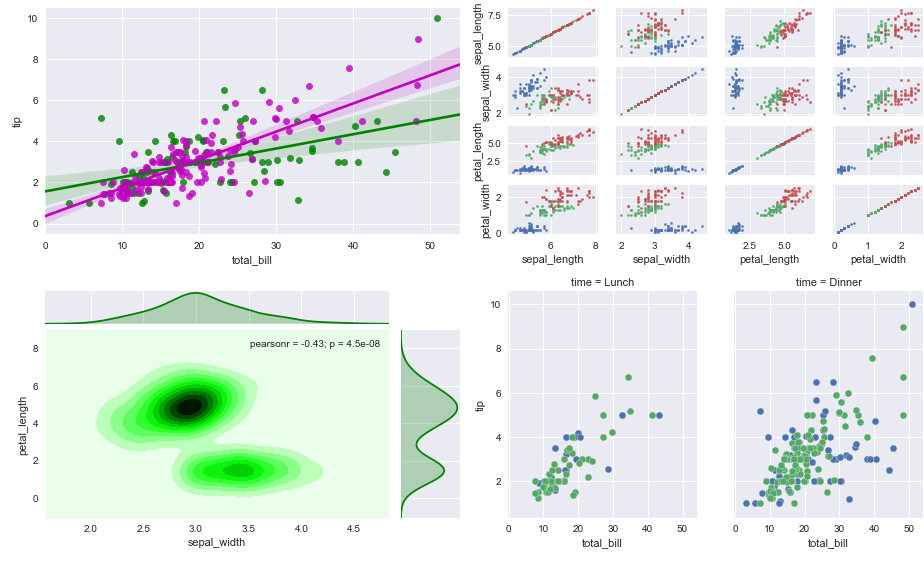

In [19]:
#import SeabornFig2Grid as sfg


sns.set()

iris = sns.load_dataset("iris")
tips = sns.load_dataset("tips")

# An lmplot
g0 = sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips, 
                palette=dict(Yes="g", No="m"))
# A PairGrid
g1 = sns.PairGrid(iris, hue="species")
g1.map(plt.scatter, s=5)
# A FacetGrid
g2 = sns.FacetGrid(tips, col="time",  hue="smoker")
g2.map(plt.scatter, "total_bill", "tip", edgecolor="w")
# A JointGrid
g3 = sns.jointplot("sepal_width", "petal_length", data=iris,
                   kind="kde", space=0, color="g")


fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(2, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[3])
mg3 = SeabornFig2Grid(g3, fig, gs[2])

gs.tight_layout(fig)
#gs.update(top=0.7)

plt.show()


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


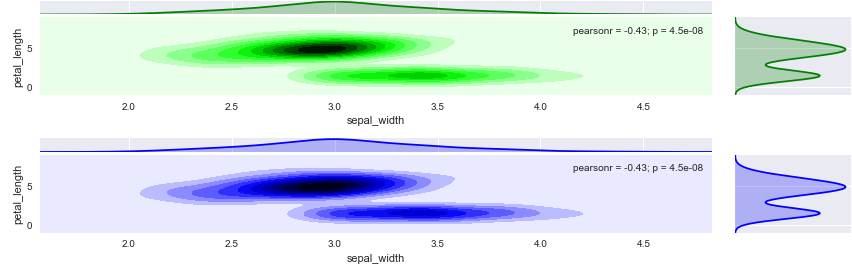

In [20]:
sns.set()

iris = sns.load_dataset("iris")
tips = sns.load_dataset("tips")

g2 = sns.jointplot("sepal_width", "petal_length", data=iris,
                   kind="kde", space=0, color="g")
g3 = sns.jointplot("sepal_width", "petal_length", data=iris,
                   kind="kde", space=0, color="b")


fig = plt.figure(figsize=(4*3,4))
gs = gridspec.GridSpec(2, 1)

#mg0 = SeabornFig2Grid(g0, fig, gs[0])
#mg1 = SeabornFig2Grid(g1, fig, gs[1])
#mg2 = SeabornFig2Grid(g2, fig, gs[3])
mg0 = SeabornFig2Grid(g2, fig, gs[0])
mg1 = SeabornFig2Grid(g3, fig, gs[1])
#mg2 = SeabornFig2Grid(g3, fig, gs[2])
gs.tight_layout(fig)
#gs.update(top=0.7)

plt.show()

### ppqqp_plot

In [21]:
def ppqqp_plot(X,name,sze=100,dist=None):
    '''
    3 plots 
    1. Percentile, a.k.a. P-P plot
    2 .Quantile, a.k.a. Q-Q plot (normal distribution)
    3. Probability, a.k.a. Prob Plot
    quick and dirty no numpy or other dist checking
    - X must be a pandas series
    - name: label name
    - size: (default: 100) is sample size of X 
    - dist: (default: none)  When using quantile or probability scales,
    you can pass a distribution from the scipy.stats module
    to the probplot function. When a distribution is not provided 
    to the dist parameter, a standard normal distribution is used.
    - return: boolean of sucess
    '''

    logger.debug('ppqqp_plot:')        
    if not ((X.dtype == np.int) or (X.dtype == np.float)):
        # not numeric
        logger.error('ppqqp was passed a distrubtion not numeric but of type: {})'.format(X.dtype))
        return(False)
    if type(X) == np.ndarray:
        if len(X) > sze: X = np.random.choice(X,sze)
    elif type(X) == pd.core.series.Series:
        if len(X) > sze: X = X.sample(sze)
    else:
        logger.error('ppqqp was passed a distrubtion not numeric but of type: {})'.format(X.dtype))
        return(False)
    ax = [0,1,3]
    fig, (ax[0], ax[1],ax[2]) = plt.subplots(figsize=(12, 4), ncols=3)
    gp = probscale.probplot(X, ax=ax[0], plottype='pp', bestfit=True,
                             problabel='Percentile', datalabel=name,
                             scatter_kws=dict(label=name),
                             line_kws=dict(label='Best Fit line'))
    fig = probscale.probplot(X, ax=ax[1], plottype='qq', bestfit=True, dist=dist,
                             problabel='Standard Normal Quantiles', datalabel=name,
                             scatter_kws=dict(label=name),
                             line_kws=dict(label='Normal QQ line'))
    fig = probscale.probplot(X, ax=ax[2], plottype='prob', bestfit=True,dist=dist,
                             problabel='Standard Normal Probalities', datalabel=name,
                             scatter_kws=dict(label=name),
                             line_kws=dict(label='Normal Probalities line'))
    ax[0].legend(loc='upper left');ax[1].legend(loc='upper left');ax[2].legend(loc='upper left')
    return(True)

### dualplot

In [22]:
def dualplot(dist,ytest):
    logger.debug('dualplot:')
    df = pd.DataFrame({'theory': dist,'actual': ytest})
    fig = plt.figure(figsize=(4,4))
    gp = sns.jointplot('actual', 'theory', df, stat_func=None, kind='hex')
    return(gp)

### Plot_Distribution_c

In [23]:
#side effect is a plot, nothing to save
# no state to save
#maybe save plot in (or X) in future version
from matplotlib import colors as mcolors

class Plot_Distribution_c(BaseTransformer):
    def __init__(self,label='',dist_name=''
                 ,title='Distribution',*args,**kwargs):
        super().__init__()
        self.title = title
        self.label = label
        self.dist_name = dist_name
        self.color_list = list(mcolors.CSS4_COLORS.keys())[51:100]
    
    def fit(self, X_o,X):
        logger.debug('Plot_Distribution_c fit:')
        return self

# X_o: orginal
# X ->  X = f(X_o)
    def transform(self, X_o,X):
        logger.debug('Plot_Distribution_c transform:')
        for feat in list(X_o.columns):  # assume df,fix later
            vth = list(X_o.columns).index(feat)
            self.dist_name = ' '+feat
            dualplot(X_o[feat],X[:,vth])
            ppqqp_plot(X[:,vth],self.label+self.dist_name)
        return self
    
    def fit_transform(self, X_o,X):
        return((self.fit(X_o,X)).transform(X_o,X))

    def load(self, filepath):
        return self

    def persist(self, filepath):
        pass

### fooplot definitions

In [24]:
def fooplot(dnames,scaler_list,size):

    for dname,args in dnames:
        for scalar in scaler_list:
            logger.debug('{}  {}:    {} '.format(scalar,args,dname))
            if args == 'none': 
                dist = StatDistributionDict[dname](size=size)
            else: 
                dist = StatDistributionDict[dname](*args,size=size)
            try: 
                gp = [0,1,2,3]
                sns.set()
                ytest = __ScalerDict__[scalar]().fit_transform(dist[:,np.newaxis])
                gp0 = dualplot(dist,ytest)
                ppqqp_plot(ytest,scalar+' '+ dname)
            except: pass
            plt.show()

In [25]:
def fooplot2(df,dnames,scaler_list,size):
    for dname in dnames:
        for scalar in scaler_list:
            try:
                dist = df[dname].values
                ytest = __ScalerDict__[scalar]().fit_transform(dist[:,np.newaxis])
                dualplot(dist,ytest)
                ppqqp_plot(ytest,scalar+dname)
            except: pass


## Statisical Distibutions Tests


In [26]:
import scipy
StatDistributionDict = {}

print('\nDistribution with no  attribute rvs method \n ===============================================')
for nth,d in enumerate(scipy.stats.__all__):
    try:
        StatDistributionDict[d] = eval('scipy.stats.'+d+'.rvs')
    except:
        logger.debug('{} {}'.format(nth,d))

print('\nDistribution attribute rvs method \n ========================================')
for nth,d in enumerate(StatDistributionDict.keys()):
    logger.info('{} {}'.format(nth,d))


Distribution with no  attribute rvs method 

Distribution attribute rvs method 
2018-10-01 20:36:48 steppy >>> 0 alpha
2018-10-01 20:36:48 steppy >>> 1 anglit
2018-10-01 20:36:48 steppy >>> 2 arcsine
2018-10-01 20:36:48 steppy >>> 3 argus
2018-10-01 20:36:48 steppy >>> 4 bernoulli
2018-10-01 20:36:48 steppy >>> 5 beta
2018-10-01 20:36:48 steppy >>> 6 betaprime
2018-10-01 20:36:48 steppy >>> 7 binom
2018-10-01 20:36:48 steppy >>> 8 boltzmann
2018-10-01 20:36:48 steppy >>> 9 bradford
2018-10-01 20:36:48 steppy >>> 10 burr
2018-10-01 20:36:48 steppy >>> 11 burr12
2018-10-01 20:36:48 steppy >>> 12 cauchy
2018-10-01 20:36:48 steppy >>> 13 chi
2018-10-01 20:36:48 steppy >>> 14 chi2
2018-10-01 20:36:48 steppy >>> 15 cosine
2018-10-01 20:36:48 steppy >>> 16 crystalball
2018-10-01 20:36:48 steppy >>> 17 dgamma
2018-10-01 20:36:48 steppy >>> 18 dirichlet
2018-10-01 20:36:48 steppy >>> 19 dlaplace
2018-10-01 20:36:48 steppy >>> 20 dweibull
2018-10-01 20:36:48 steppy >>> 21 erlang
2018-10-01 20:3

###  Scalar Transform .vs. Original Distribution Joint Plot

#### Standard Distibutions

In [27]:
size = 10000
dist = StatDistributionDict['cauchy'](size=size)

In [28]:
__ScalerDict__['LambertScaler']

toolkit.preprocessing.scalers.LambertScaler

In [29]:
dnames = [['beta',[2.0,1.0]],['alpha',[0.75]]
          ,['uniform','none'],['cauchy','none']
          ,['ksone',[1000]],['boltzmann',[1.4, 19]]
          ,['laplace',[3.0]],['tukeylambda',[3.0]]
          ,['dweibull',[3.0]],['chi2',[3.0]]
          ,['exponnorm',[1]],['norm','none']]

scaler_list = ['BoxCoxScaler','LambertScaler'
               ,'StandardScaler','MinMaxScaler']
size = 10000
fooplot(dnames,scaler_list,size)


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


#### Housing

In [30]:
df = Housing
dnames = list(df.columns)
scaler_list = ['BoxCoxScaler','LambertScaler'
               ,'StandardScaler','MinMaxScaler']
size = 10000

fooplot2(df,dnames,scaler_list,size)

- every transform has problems last bin of HOUSEAGE. This last could be a clip, which could be modeled as same distbution with a width of 50 (parmeterize year extension number) An experiment for another day
- MINMAX probably does best on AVGBEDRMS at transforming into Gaussian
- BOOXCOX does well on AVEROCCUP!!!!!

#### City

In [31]:
df = City
dnames = list(df.columns)

scaler_list = ['BoxCoxScaler','LambertScaler'
               ,'StandardScaler','MinMaxScaler']

size = 10000

fooplot2(df,dnames,scaler_list,size)

- 'BoxCoxScaler','LambertScaler' do best on the continuous features

#### Hip male

df = hip_m
dnames = list(df.columns)

scaler_list = ['BoxCoxScaler','LambertScaler'
               'StandardScaler','MinMaxScaler']

size = 10000

fooplot2(df,dnames,scaler_list,size)

#### Conclusions

- BoxCox is better than Lambert at transforming into Gaussian (halfgennorm,chisq
- - wont work on negative values (Cauchy,laplace
- Lambert is best at bringing right or left tails towards center (by about 2 or more stds) and best at not-perturbing (changing) balanced distributions (uniform,dweibull)
- although Standard and Robust are even better at not-perturbing any distribution

- use BoxCox to transform to Gaussian
- use Lambert for distributions with outliers to transform to more centered (less skewnn)
- use Standard to put any feature on a standard scale

#  Steps

## Adaptors

In [32]:
MODELS_DIR = '../input/models'
EXPERIMENT_DIR = MODELS_DIR+'/tmp'
!mkdir $MODELS_DIR
!mkdir $EXPERIMENT_DIR
import shutil

# By default pipelines will try to load previously trained models so we delete the cache to ba sure we're starting from scratch
shutil.rmtree(EXPERIMENT_DIR, ignore_errors=True)


mkdir: ../input/models: File exists
mkdir: ../input/models/tmp: File exists


In [33]:
some_other_bound_variable = 0
Housing_o = Housing.copy()
data_Housing = {
    'input': {
        'features': Housing,
        'features_o': Housing_o,
        'etc': some_other_bound_variable
    }
}
City_o = City.copy()
data_City = {
    'input': {
        'features': City,
        'features_o': City_o
    }
}


Hip_m_o = Hip_m.copy()
data_Hip_m = {
    'input': {
        'features': Hip_m,
        'features_o': Hip_m_o
    }
}

## LambertScaler -Step Testing

In [34]:
LambertScaler_step = Step(name='Steppy_Scaler_L',
               transformer=S_Scaler('LambertScaler'),
               input_data=['input'],
               adapter=Adapter({
                   'X': E('input','features_o')
               }),
               experiment_directory=EXPERIMENT_DIR,
                is_trainable=True,
                force_fitting=True)

2018-10-01 20:37:15 steppy >>> initializing Step Steppy_Scaler_L...
2018-10-01 20:37:15 steppy >>> initializing experiment directories under ../input/models/tmp
2018-10-01 20:37:15 steppy >>> done: initializing experiment directories
2018-10-01 20:37:15 steppy >>> Step Steppy_Scaler_L initialized


In [35]:
LambertScaler_step.fit_transform(data_Housing)['X'][:,0][:,np.newaxis].shape

2018-10-01 20:37:16 steppy >>> Step Steppy_Scaler_L, adapting inputs...
2018-10-01 20:37:16 steppy >>> Step Steppy_Scaler_L, fitting and transforming...
2018-10-01 20:37:21 steppy >>> Step Steppy_Scaler_L, persisting transformer to the ../input/models/tmp/transformers/Steppy_Scaler_L


(20640, 1)

In [36]:
import graphviz
#.LambertScaler_step

## StandardScaler - Step Testing 

In [37]:
StandardScaler_step = Step(name='Steppy_Scaler_S',
               transformer=S_Scaler('StandardScaler'),
               input_data=['input'],
               adapter=Adapter({
                   'X': E('input','features_o')
               }),
               experiment_directory=EXPERIMENT_DIR,
                       is_trainable=True,
                       force_fitting=True)

2018-10-01 20:37:21 steppy >>> initializing Step Steppy_Scaler_S...
2018-10-01 20:37:21 steppy >>> initializing experiment directories under ../input/models/tmp
2018-10-01 20:37:21 steppy >>> done: initializing experiment directories
2018-10-01 20:37:21 steppy >>> Step Steppy_Scaler_S initialized


In [38]:
StandardScaler_step.fit_transform(data_Housing)['X'][:,0][:,np.newaxis].shape

2018-10-01 20:37:21 steppy >>> Step Steppy_Scaler_S, adapting inputs...
2018-10-01 20:37:21 steppy >>> Step Steppy_Scaler_S, fitting and transforming...
2018-10-01 20:37:21 steppy >>> Step Steppy_Scaler_S, persisting transformer to the ../input/models/tmp/transformers/Steppy_Scaler_S


(20640, 1)

## BoxCoxEncoder - Step Testing -FAIL

In [39]:
# should fail
try:
    n = 'BoxCoxEncoder'
    e = Steppy_Scaler(n,verbose=True)
except:
    print('BoxCoxEncoder ***error*** should be BoxCoxScaler')


BoxCoxEncoder ***error*** should be BoxCoxScaler


##  Lots of Scale Steps Test

In [40]:
scaler_list = ['BoxCoxScaler','LambertScaler','StandardScaler','MinMaxScaler']
Scale_steps = [Step(name='S_Scaler_{}'.format(scaler),
                 transformer=S_Scaler(scaler),
                 input_data=['input'],
                 adapter=Adapter({
                       'X': E('input','features')
                }),    
               experiment_directory=EXPERIMENT_DIR,
                is_trainable=True,
                force_fitting=True)
            for nth, scaler in enumerate(scaler_list)]

2018-10-01 20:37:21 steppy >>> initializing Step S_Scaler_BoxCoxScaler...
2018-10-01 20:37:21 steppy >>> initializing experiment directories under ../input/models/tmp
2018-10-01 20:37:21 steppy >>> done: initializing experiment directories
2018-10-01 20:37:21 steppy >>> Step S_Scaler_BoxCoxScaler initialized
2018-10-01 20:37:21 steppy >>> initializing Step S_Scaler_LambertScaler...
2018-10-01 20:37:21 steppy >>> initializing experiment directories under ../input/models/tmp
2018-10-01 20:37:21 steppy >>> done: initializing experiment directories
2018-10-01 20:37:21 steppy >>> Step S_Scaler_LambertScaler initialized
2018-10-01 20:37:21 steppy >>> initializing Step S_Scaler_StandardScaler...
2018-10-01 20:37:21 steppy >>> initializing experiment directories under ../input/models/tmp
2018-10-01 20:37:21 steppy >>> done: initializing experiment directories
2018-10-01 20:37:21 steppy >>> Step S_Scaler_StandardScaler initialized
2018-10-01 20:37:21 steppy >>> initializing Step S_Scaler_MinMax

In [41]:
Scale_steps[1].fit_transform(data_Housing)['X'][:,1][:,np.newaxis].shape

2018-10-01 20:37:21 steppy >>> Step S_Scaler_LambertScaler, adapting inputs...
2018-10-01 20:37:21 steppy >>> Step S_Scaler_LambertScaler, fitting and transforming...
2018-10-01 20:37:27 steppy >>> Step S_Scaler_LambertScaler, persisting transformer to the ../input/models/tmp/transformers/S_Scaler_LambertScaler


(20640, 1)

In [42]:
Scale_steps[0].name[14:]

'xScaler'

2018-10-01 20:37:27 steppy >>> Step S_Scaler_BoxCoxScaler, adapting inputs...
2018-10-01 20:37:27 steppy >>> Step S_Scaler_BoxCoxScaler, fitting and transforming...
2018-10-01 20:37:27 steppy >>> Step S_Scaler_BoxCoxScaler, persisting transformer to the ../input/models/tmp/transformers/S_Scaler_BoxCoxScaler


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy

<Figure size 288x288 with 0 Axes>

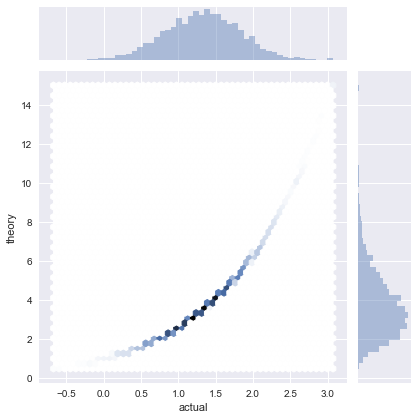

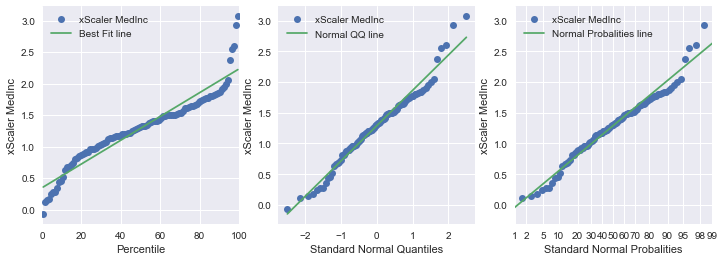

<Figure size 288x288 with 0 Axes>

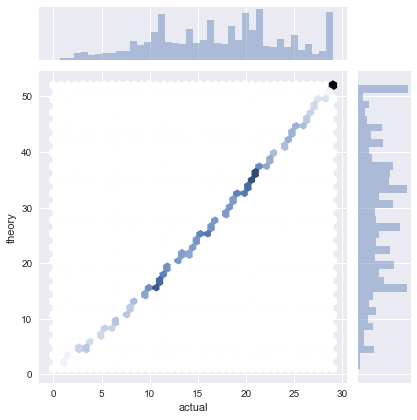

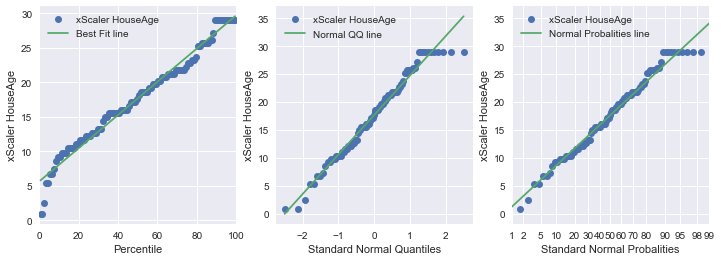

<Figure size 288x288 with 0 Axes>

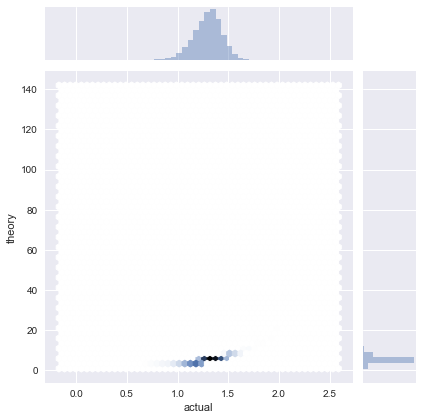

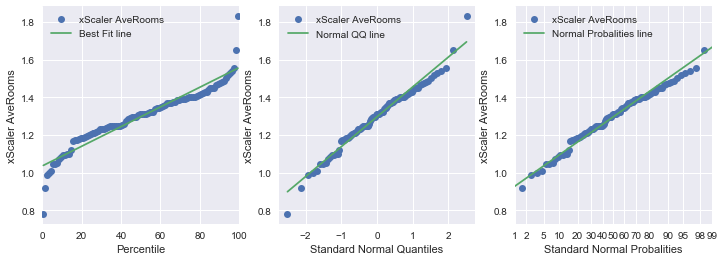

<Figure size 288x288 with 0 Axes>

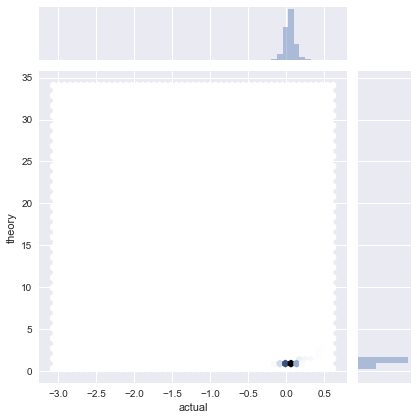

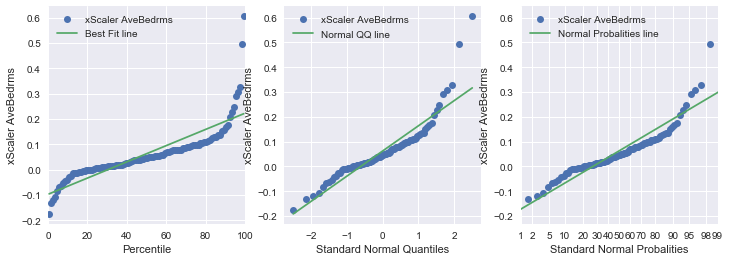

<Figure size 288x288 with 0 Axes>

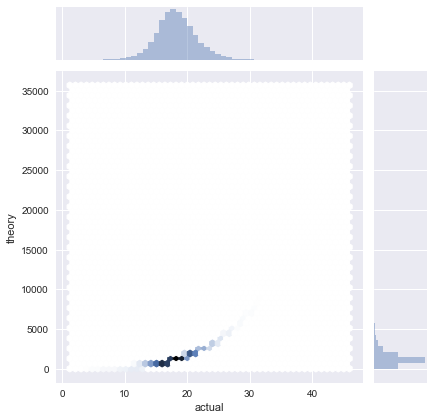

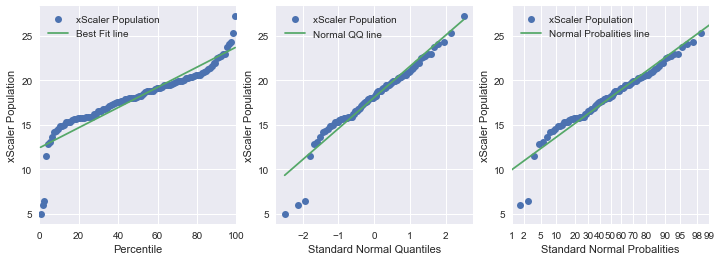

<Figure size 288x288 with 0 Axes>

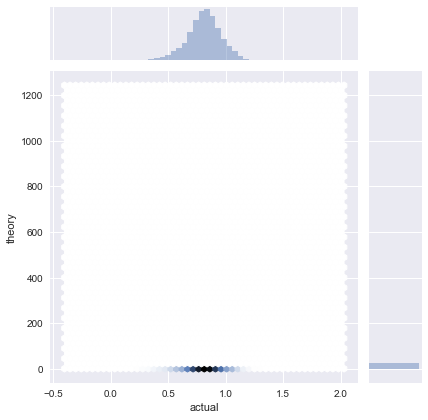

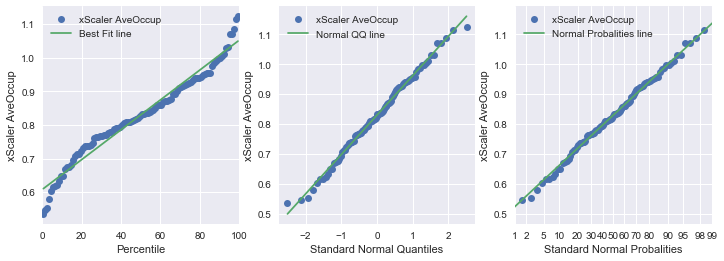

In [43]:
pc = Plot_Distribution_c()
feat = 'MedInc'
x_o = Housing
ytest = Scale_steps[0].fit_transform(data_Housing)['X']
pc.label = Scale_steps[0].name[14:]
pc.transform(x_o,ytest)


# Plot Testing of Scalers

## Plot_Gaussian_step

In [44]:
#color_list = list(mcolors.CSS4_COLORS.keys())[51:100]
Plot_Gaussian_step \
    = [Step(name='Plot_Gaussian_{}'.format(astep.name),
           transformer=Plot_Distribution_c(label=astep.name[14:]),
           input_steps=[astep], 
           input_data=['input'],
            adapter=Adapter({
                   'X_o': E('input','features_o'),
                   'X': E(astep.name,'X')
            }),
            experiment_directory=EXPERIMENT_DIR,
           is_trainable=True,
           force_fitting=True)
            for nth, astep in enumerate(list(Scale_steps))]



2018-10-01 20:37:35 steppy >>> initializing Step Plot_Gaussian_S_Scaler_BoxCoxScaler...
2018-10-01 20:37:35 steppy >>> initializing experiment directories under ../input/models/tmp
2018-10-01 20:37:35 steppy >>> done: initializing experiment directories
2018-10-01 20:37:35 steppy >>> Step Plot_Gaussian_S_Scaler_BoxCoxScaler initialized
2018-10-01 20:37:35 steppy >>> initializing Step Plot_Gaussian_S_Scaler_LambertScaler...
2018-10-01 20:37:35 steppy >>> initializing experiment directories under ../input/models/tmp
2018-10-01 20:37:35 steppy >>> done: initializing experiment directories
2018-10-01 20:37:35 steppy >>> Step Plot_Gaussian_S_Scaler_LambertScaler initialized
2018-10-01 20:37:35 steppy >>> initializing Step Plot_Gaussian_S_Scaler_StandardScaler...
2018-10-01 20:37:35 steppy >>> initializing experiment directories under ../input/models/tmp
2018-10-01 20:37:35 steppy >>> done: initializing experiment directories
2018-10-01 20:37:35 steppy >>> Step Plot_Gaussian_S_Scaler_Standar

## Plot_Gaussian_step Step Test

### Cauchy Step Input

In [45]:
dname ='cauchy'
dist = StatDistributionDict[dname](size=1000)

In [46]:
data_Dist = {
    'input': {
        'features': dist
    }
}
#Plot_Gaussian_step[0]

InvocationException: GraphViz's executables not found

### Housing Plot_Gaussian_step

2018-10-01 20:37:35 steppy >>> Step S_Scaler_BoxCoxScaler, adapting inputs...
2018-10-01 20:37:35 steppy >>> Step S_Scaler_BoxCoxScaler, fitting and transforming...
2018-10-01 20:37:36 steppy >>> Step S_Scaler_BoxCoxScaler, persisting transformer to the ../input/models/tmp/transformers/S_Scaler_BoxCoxScaler
2018-10-01 20:37:36 steppy >>> Step Plot_Gaussian_S_Scaler_BoxCoxScaler, adapting inputs...
2018-10-01 20:37:36 steppy >>> Step Plot_Gaussian_S_Scaler_BoxCoxScaler, fitting and transforming...


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy

2018-10-01 20:37:37 steppy >>> Step Plot_Gaussian_S_Scaler_BoxCoxScaler, persisting transformer to the ../input/models/tmp/transformers/Plot_Gaussian_S_Scaler_BoxCoxScaler
2018-10-01 20:37:37 steppy >>> Step S_Scaler_LambertScaler, adapting inputs...
2018-10-01 20:37:37 steppy >>> Step S_Scaler_LambertScaler, fitting and transforming...


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


2018-10-01 20:37:43 steppy >>> Step S_Scaler_LambertScaler, persisting transformer to the ../input/models/tmp/transformers/S_Scaler_LambertScaler
2018-10-01 20:37:43 steppy >>> Step Plot_Gaussian_S_Scaler_LambertScaler, adapting inputs...
2018-10-01 20:37:43 steppy >>> Step Plot_Gaussian_S_Scaler_LambertScaler, fitting and transforming...


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotli

2018-10-01 20:37:45 steppy >>> Step Plot_Gaussian_S_Scaler_LambertScaler, persisting transformer to the ../input/models/tmp/transformers/Plot_Gaussian_S_Scaler_LambertScaler
2018-10-01 20:37:45 steppy >>> Step S_Scaler_StandardScaler, adapting inputs...
2018-10-01 20:37:45 steppy >>> Step S_Scaler_StandardScaler, fitting and transforming...
2018-10-01 20:37:45 steppy >>> Step S_Scaler_StandardScaler, persisting transformer to the ../input/models/tmp/transformers/S_Scaler_StandardScaler
2018-10-01 20:37:45 steppy >>> Step Plot_Gaussian_S_Scaler_StandardScaler, adapting inputs...
2018-10-01 20:37:45 steppy >>> Step Plot_Gaussian_S_Scaler_StandardScaler, fitting and transforming...


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm

2018-10-01 20:37:46 steppy >>> Step Plot_Gaussian_S_Scaler_StandardScaler, persisting transformer to the ../input/models/tmp/transformers/Plot_Gaussian_S_Scaler_StandardScaler
2018-10-01 20:37:46 steppy >>> Step S_Scaler_MinMaxScaler, adapting inputs...
2018-10-01 20:37:46 steppy >>> Step S_Scaler_MinMaxScaler, fitting and transforming...
2018-10-01 20:37:46 steppy >>> Step S_Scaler_MinMaxScaler, persisting transformer to the ../input/models/tmp/transformers/S_Scaler_MinMaxScaler
2018-10-01 20:37:46 steppy >>> Step Plot_Gaussian_S_Scaler_MinMaxScaler, adapting inputs...
2018-10-01 20:37:46 steppy >>> Step Plot_Gaussian_S_Scaler_MinMaxScaler, fitting and transforming...


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm

2018-10-01 20:37:48 steppy >>> Step Plot_Gaussian_S_Scaler_MinMaxScaler, persisting transformer to the ../input/models/tmp/transformers/Plot_Gaussian_S_Scaler_MinMaxScaler


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 288x288 with 0 Axes>

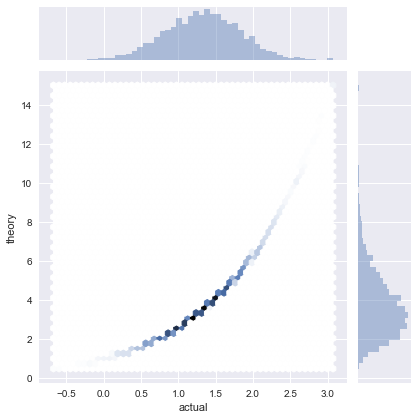

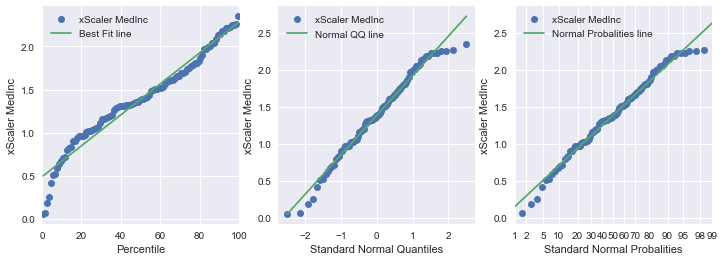

<Figure size 288x288 with 0 Axes>

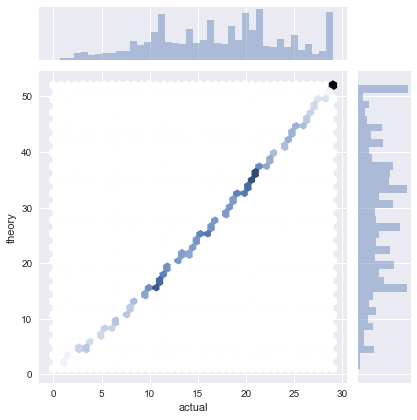

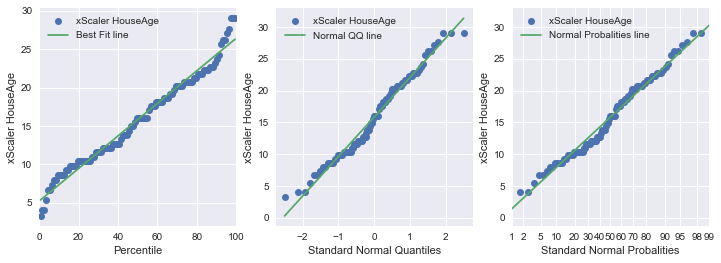

<Figure size 288x288 with 0 Axes>

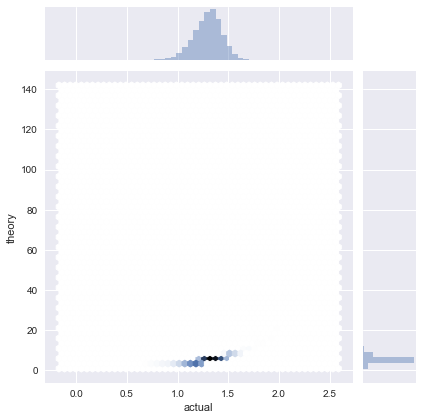

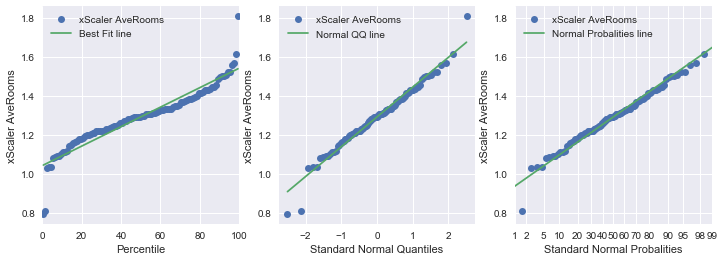

<Figure size 288x288 with 0 Axes>

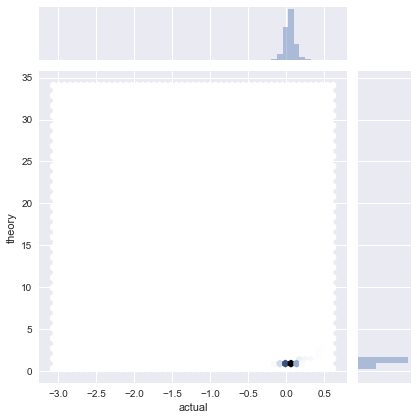

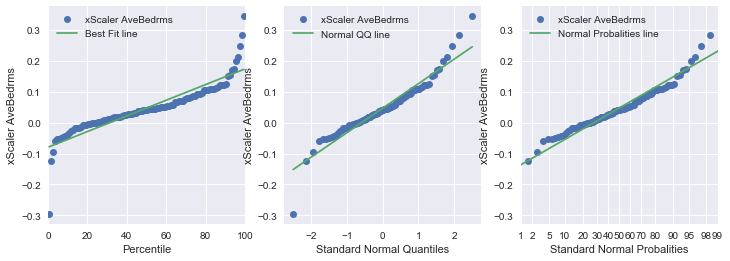

<Figure size 288x288 with 0 Axes>

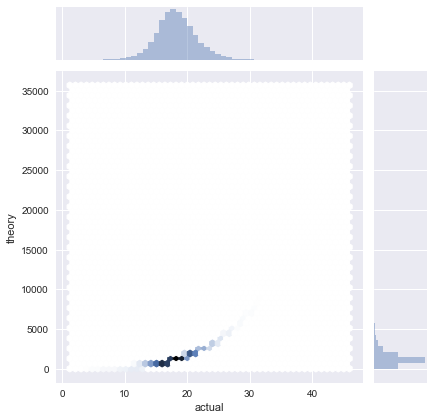

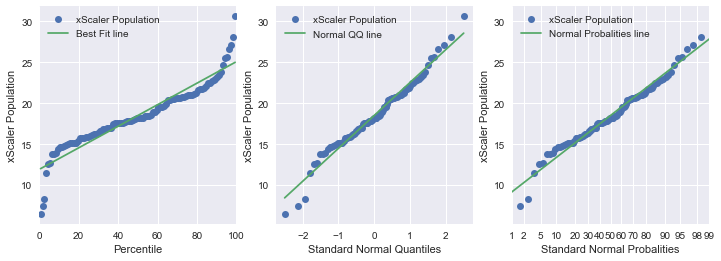

<Figure size 288x288 with 0 Axes>

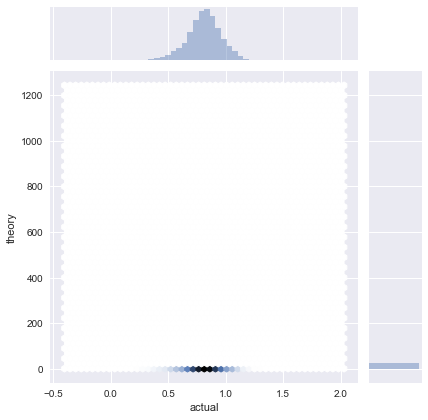

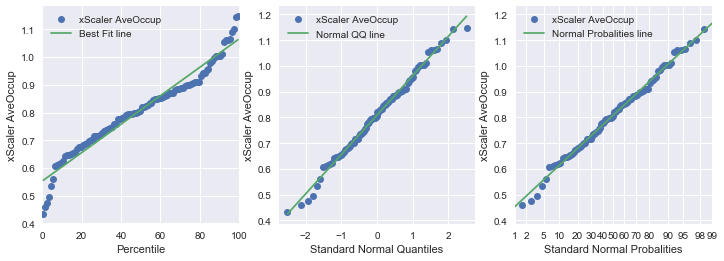

<Figure size 288x288 with 0 Axes>

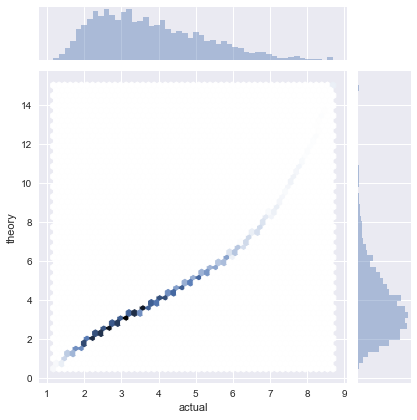

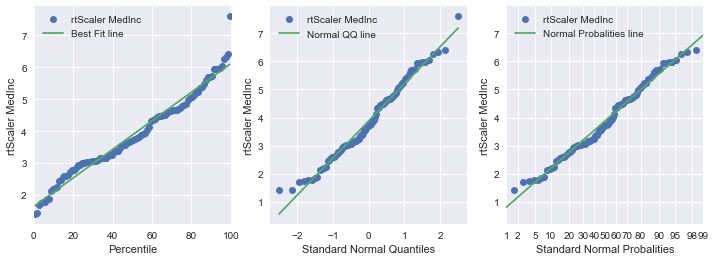

<Figure size 288x288 with 0 Axes>

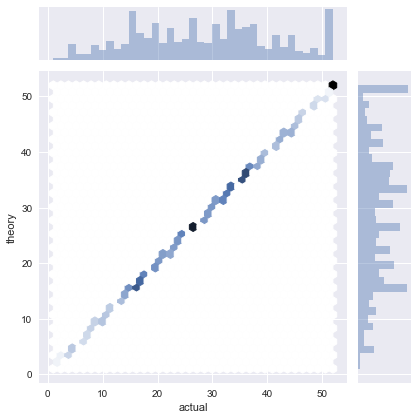

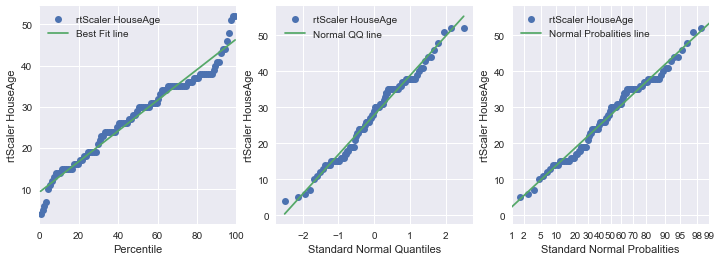

<Figure size 288x288 with 0 Axes>

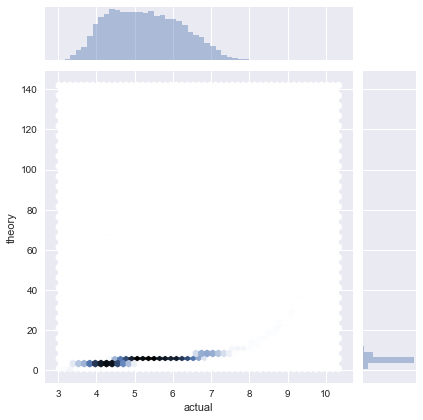

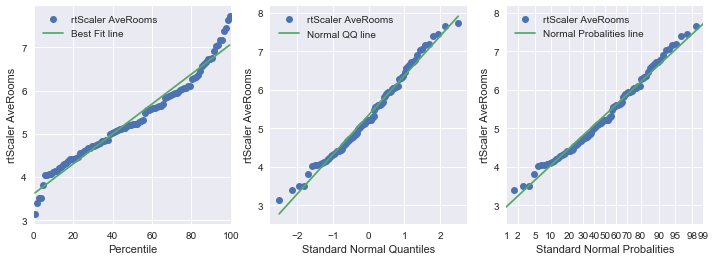

<Figure size 288x288 with 0 Axes>

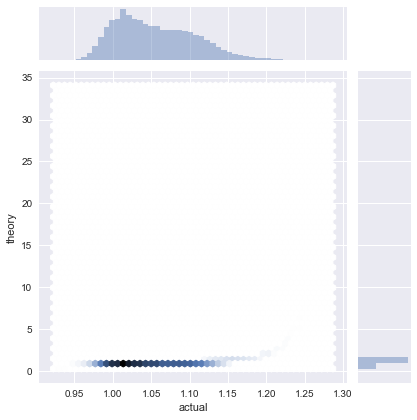

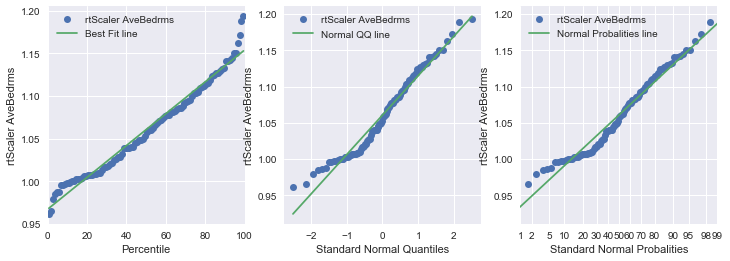

<Figure size 288x288 with 0 Axes>

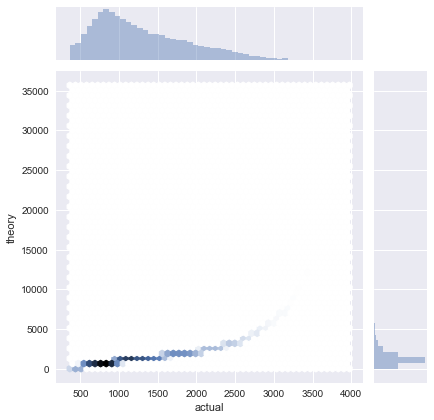

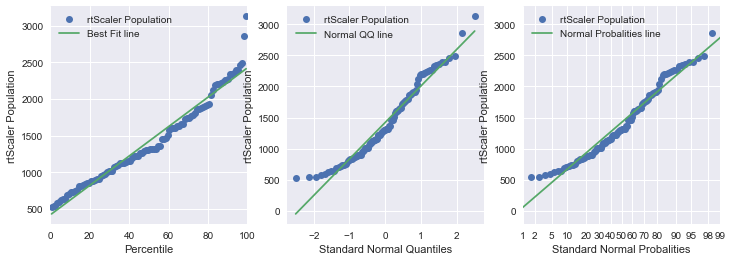

<Figure size 288x288 with 0 Axes>

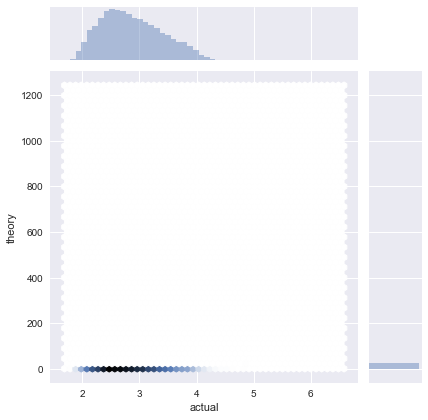

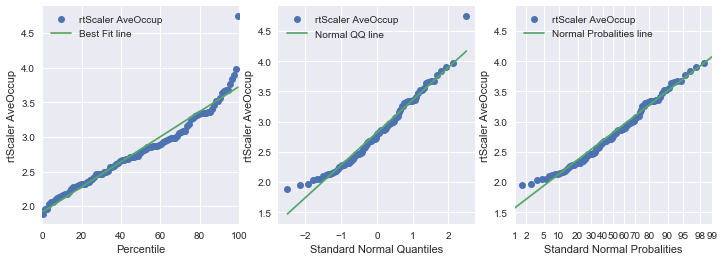

<Figure size 288x288 with 0 Axes>

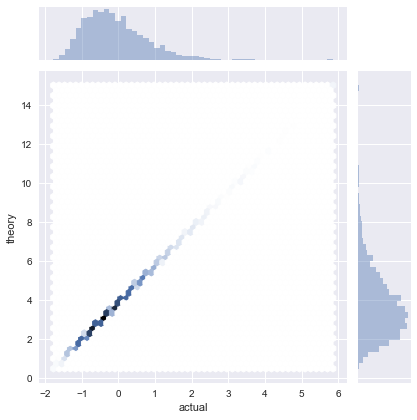

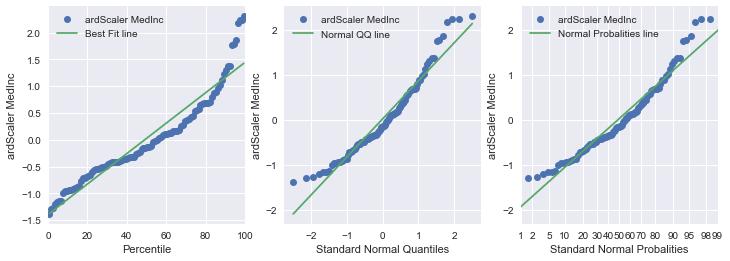

<Figure size 288x288 with 0 Axes>

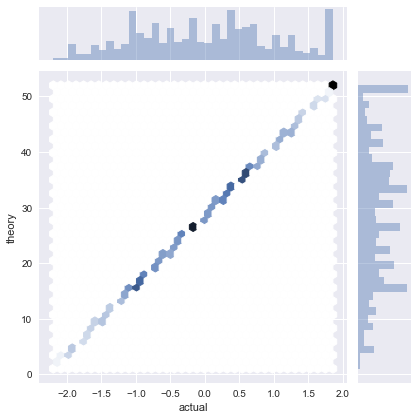

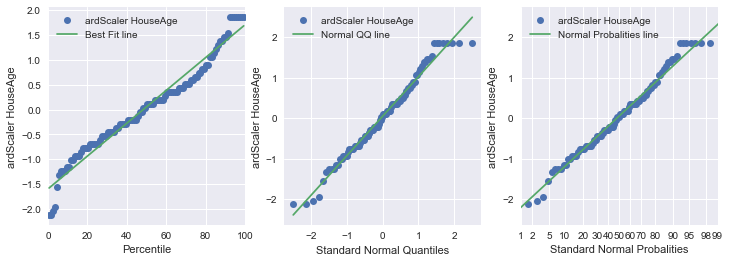

<Figure size 288x288 with 0 Axes>

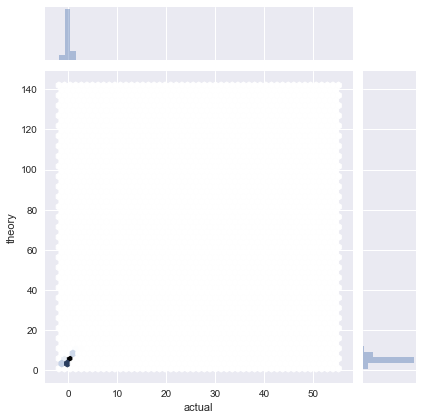

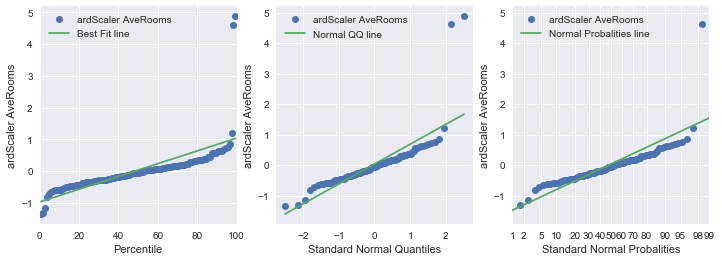

<Figure size 288x288 with 0 Axes>

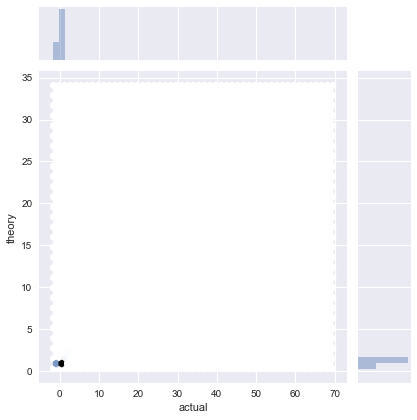

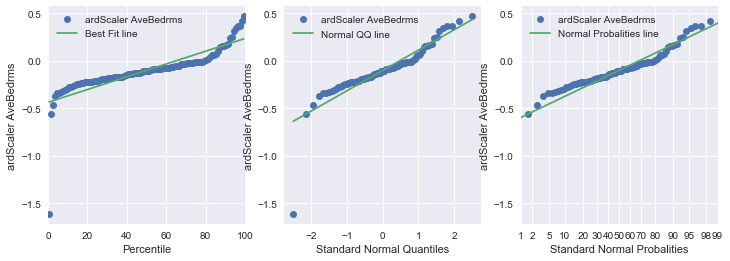

<Figure size 288x288 with 0 Axes>

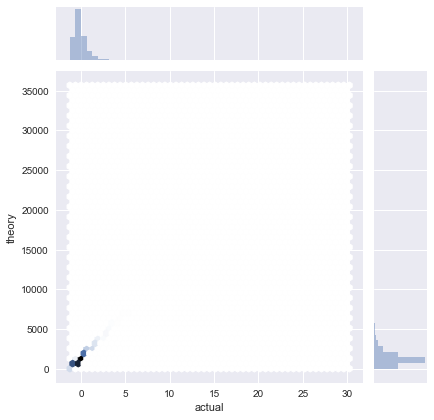

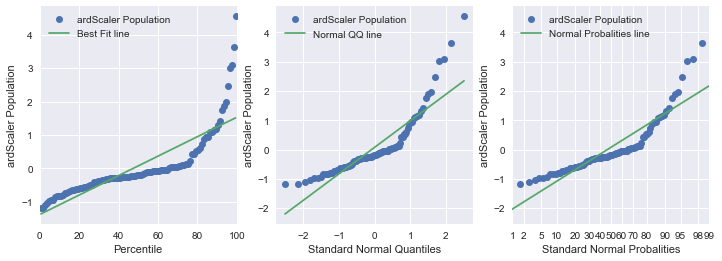

<Figure size 288x288 with 0 Axes>

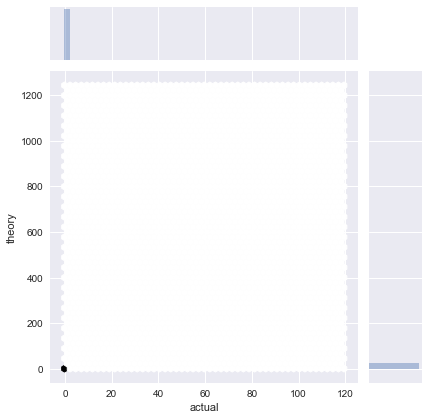

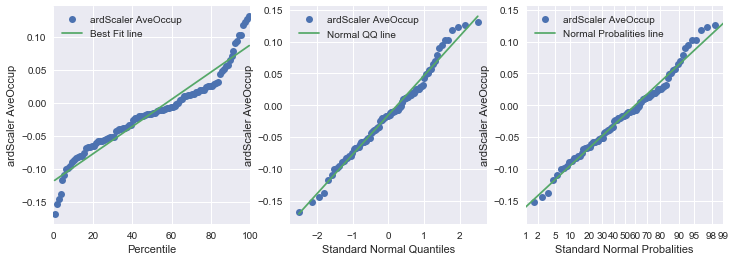

<Figure size 288x288 with 0 Axes>

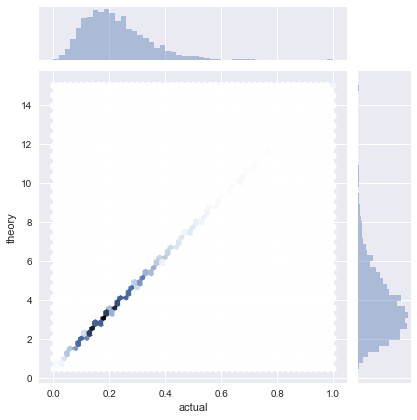

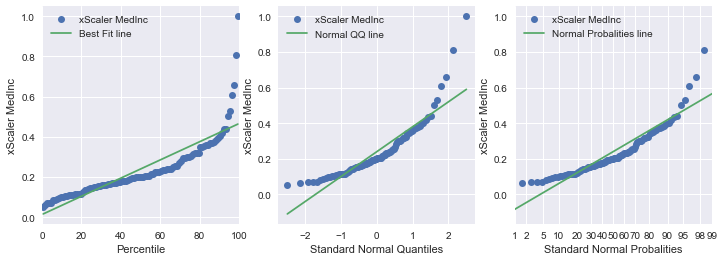

<Figure size 288x288 with 0 Axes>

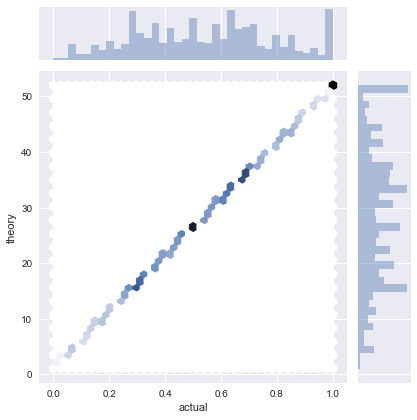

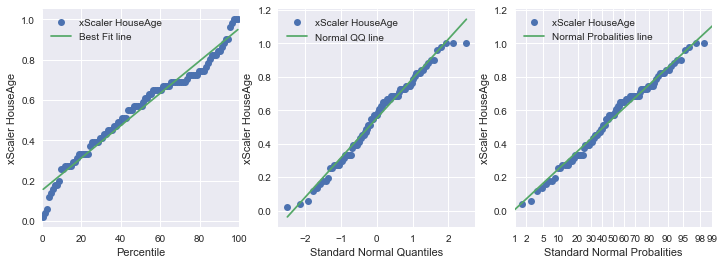

<Figure size 288x288 with 0 Axes>

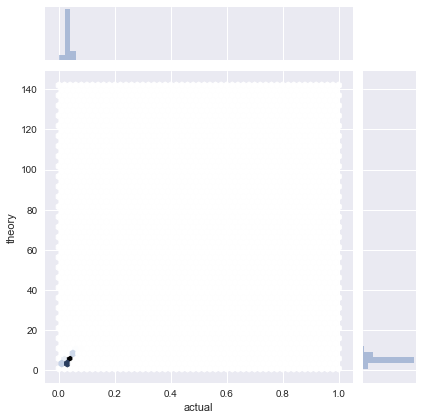

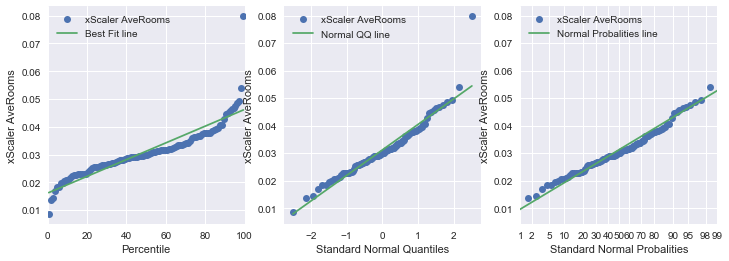

<Figure size 288x288 with 0 Axes>

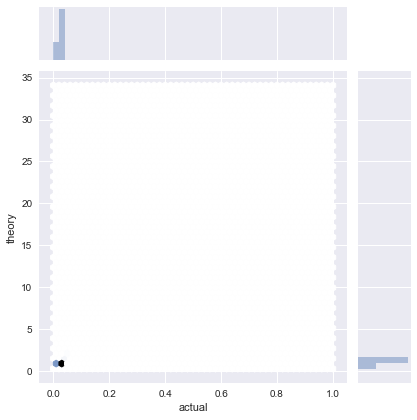

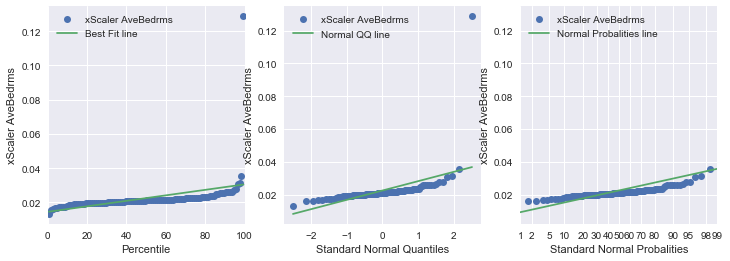

<Figure size 288x288 with 0 Axes>

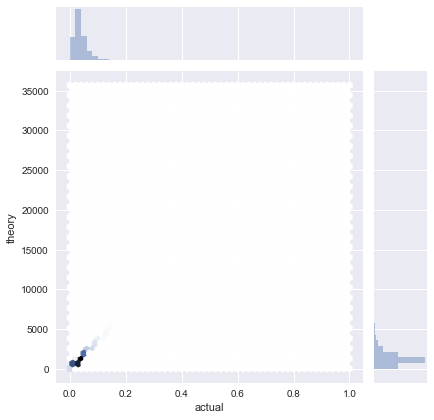

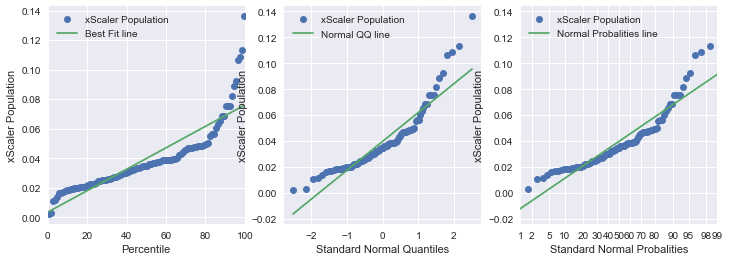

<Figure size 288x288 with 0 Axes>

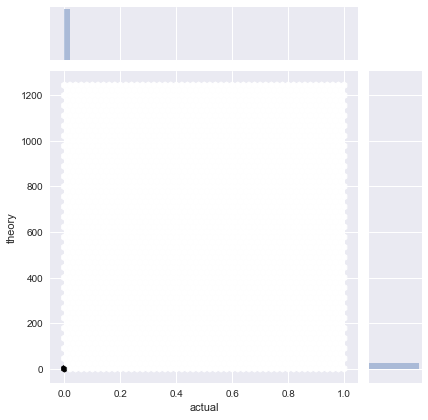

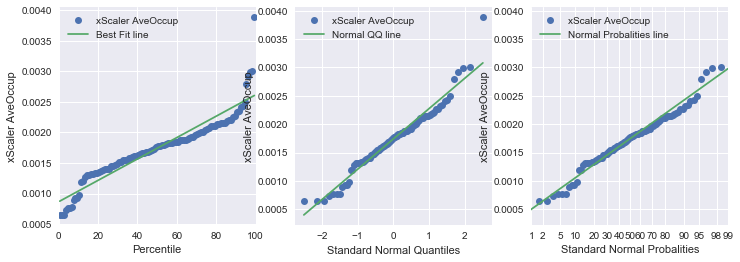

In [47]:
for Plot_Gaussian_step_nth in Plot_Gaussian_step:
    Plot_Gaussian_step_nth.fit_transform(data_Housing)

### City Plot_Gaussian_step

2018-10-01 20:38:14 steppy >>> Step S_Scaler_BoxCoxScaler, adapting inputs...
2018-10-01 20:38:14 steppy >>> Step S_Scaler_BoxCoxScaler, fitting and transforming...
2018-10-01 20:38:14 steppy >>> Step S_Scaler_BoxCoxScaler, persisting transformer to the ../input/models/tmp/transformers/S_Scaler_BoxCoxScaler
2018-10-01 20:38:14 steppy >>> Step Plot_Gaussian_S_Scaler_BoxCoxScaler, adapting inputs...
2018-10-01 20:38:14 steppy >>> Step Plot_Gaussian_S_Scaler_BoxCoxScaler, fitting and transforming...


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy

2018-10-01 20:38:15 steppy >>> Step Plot_Gaussian_S_Scaler_BoxCoxScaler, persisting transformer to the ../input/models/tmp/transformers/Plot_Gaussian_S_Scaler_BoxCoxScaler
2018-10-01 20:38:15 steppy >>> Step S_Scaler_LambertScaler, adapting inputs...
2018-10-01 20:38:15 steppy >>> Step S_Scaler_LambertScaler, fitting and transforming...


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


2018-10-01 20:38:16 steppy >>> Step S_Scaler_LambertScaler, persisting transformer to the ../input/models/tmp/transformers/S_Scaler_LambertScaler
2018-10-01 20:38:16 steppy >>> Step Plot_Gaussian_S_Scaler_LambertScaler, adapting inputs...
2018-10-01 20:38:16 steppy >>> Step Plot_Gaussian_S_Scaler_LambertScaler, fitting and transforming...


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotli

2018-10-01 20:38:17 steppy >>> Step Plot_Gaussian_S_Scaler_LambertScaler, persisting transformer to the ../input/models/tmp/transformers/Plot_Gaussian_S_Scaler_LambertScaler
2018-10-01 20:38:17 steppy >>> Step S_Scaler_StandardScaler, adapting inputs...
2018-10-01 20:38:17 steppy >>> Step S_Scaler_StandardScaler, fitting and transforming...
2018-10-01 20:38:17 steppy >>> Step S_Scaler_StandardScaler, persisting transformer to the ../input/models/tmp/transformers/S_Scaler_StandardScaler
2018-10-01 20:38:17 steppy >>> Step Plot_Gaussian_S_Scaler_StandardScaler, adapting inputs...
2018-10-01 20:38:17 steppy >>> Step Plot_Gaussian_S_Scaler_StandardScaler, fitting and transforming...


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm

2018-10-01 20:38:19 steppy >>> Step Plot_Gaussian_S_Scaler_StandardScaler, persisting transformer to the ../input/models/tmp/transformers/Plot_Gaussian_S_Scaler_StandardScaler
2018-10-01 20:38:19 steppy >>> Step S_Scaler_MinMaxScaler, adapting inputs...
2018-10-01 20:38:19 steppy >>> Step S_Scaler_MinMaxScaler, fitting and transforming...
2018-10-01 20:38:19 steppy >>> Step S_Scaler_MinMaxScaler, persisting transformer to the ../input/models/tmp/transformers/S_Scaler_MinMaxScaler
2018-10-01 20:38:19 steppy >>> Step Plot_Gaussian_S_Scaler_MinMaxScaler, adapting inputs...
2018-10-01 20:38:19 steppy >>> Step Plot_Gaussian_S_Scaler_MinMaxScaler, fitting and transforming...


/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brucecottman/anaconda3/envs/steppy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm

2018-10-01 20:38:20 steppy >>> Step Plot_Gaussian_S_Scaler_MinMaxScaler, persisting transformer to the ../input/models/tmp/transformers/Plot_Gaussian_S_Scaler_MinMaxScaler


<Figure size 288x288 with 0 Axes>

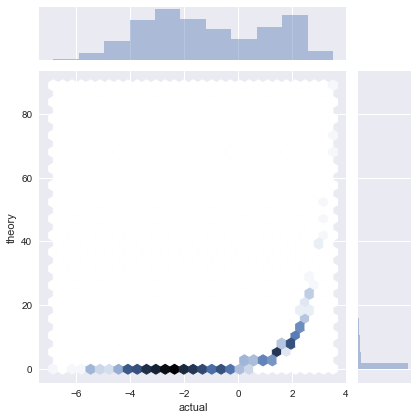

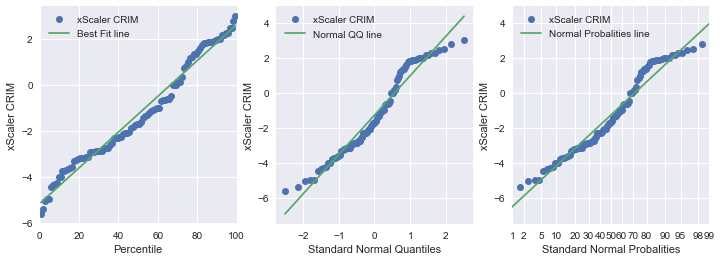

<Figure size 288x288 with 0 Axes>

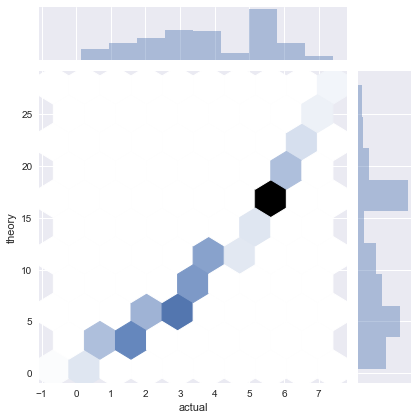

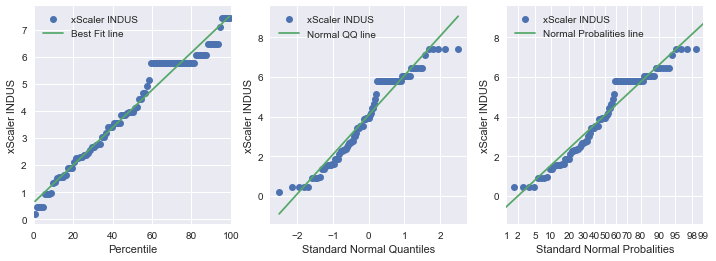

<Figure size 288x288 with 0 Axes>

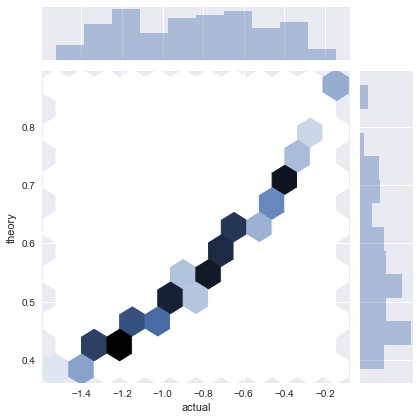

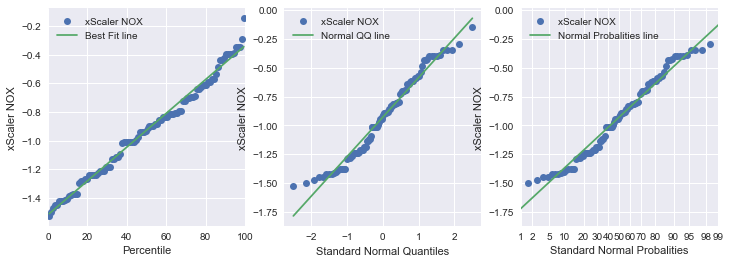

<Figure size 288x288 with 0 Axes>

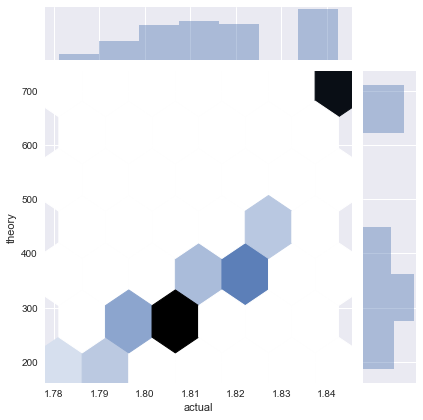

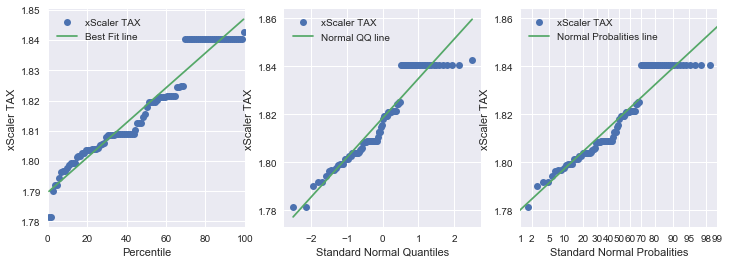

<Figure size 288x288 with 0 Axes>

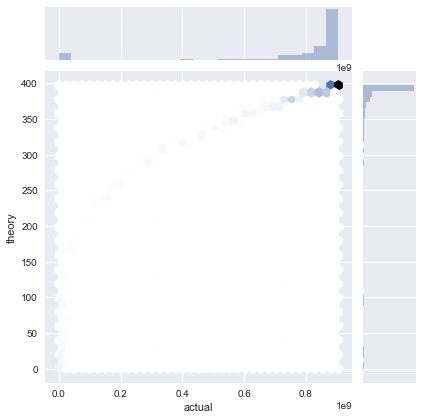

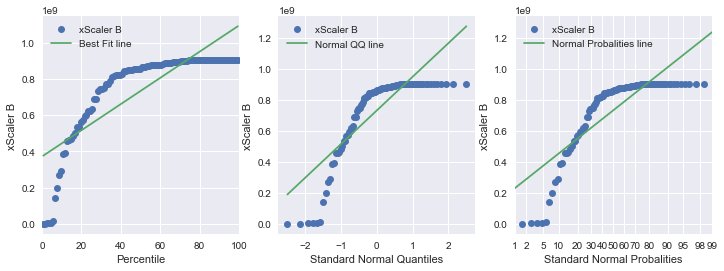

<Figure size 288x288 with 0 Axes>

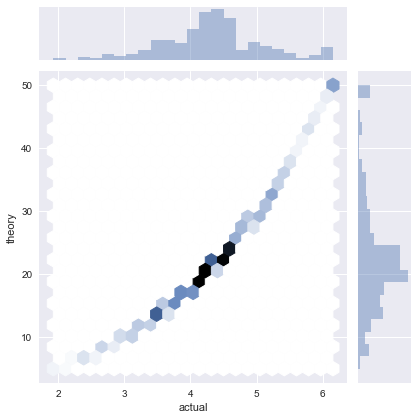

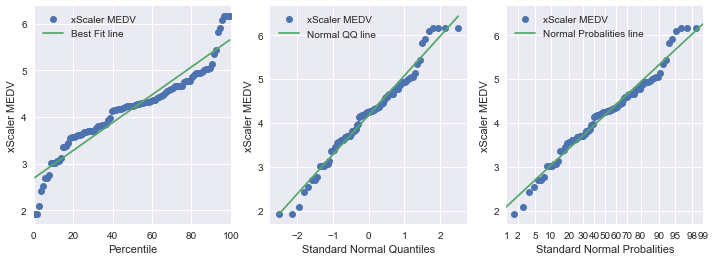

<Figure size 288x288 with 0 Axes>

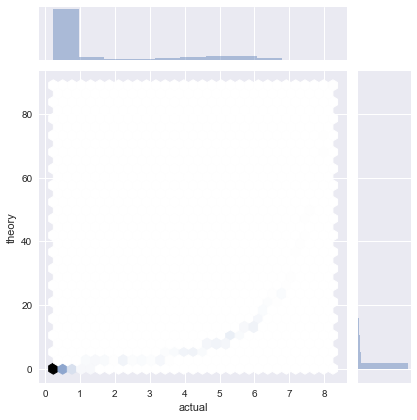

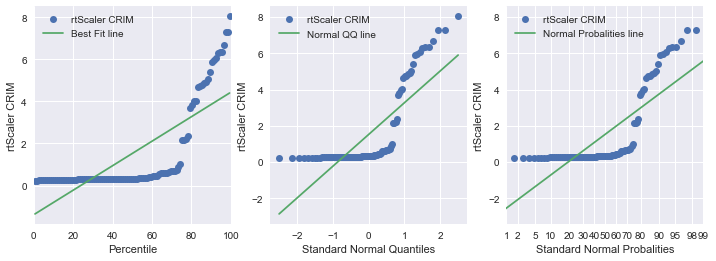

<Figure size 288x288 with 0 Axes>

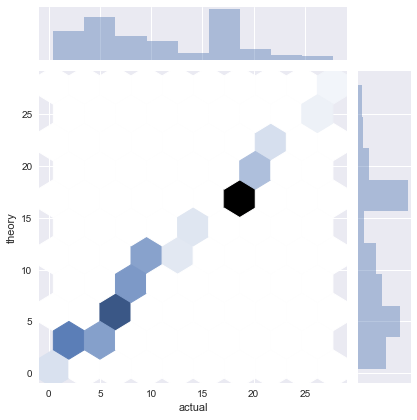

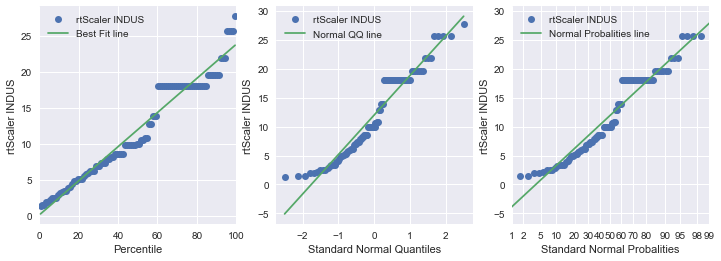

<Figure size 288x288 with 0 Axes>

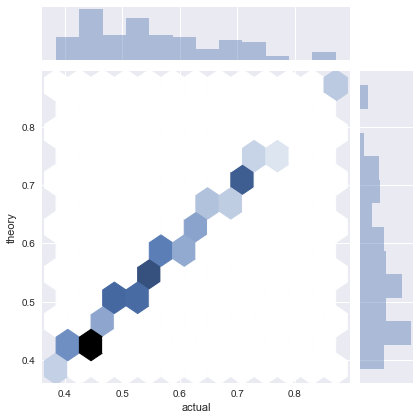

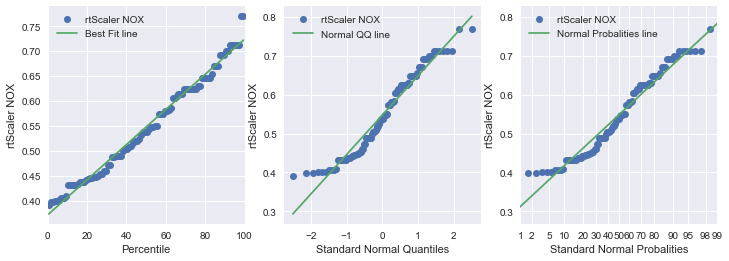

<Figure size 288x288 with 0 Axes>

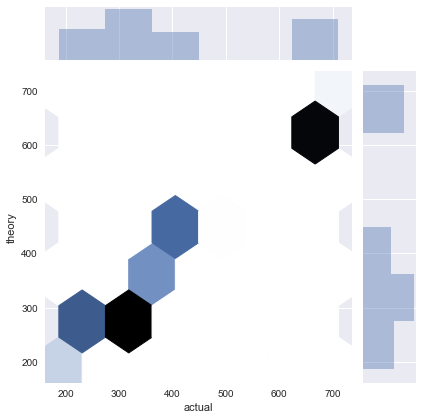

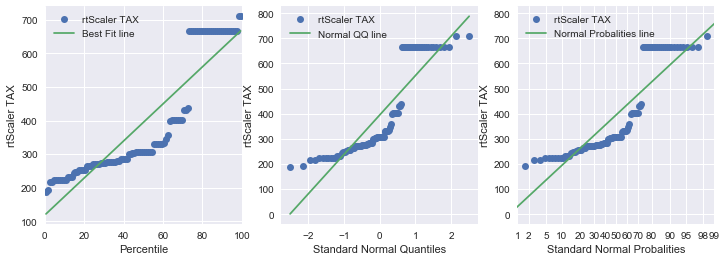

<Figure size 288x288 with 0 Axes>

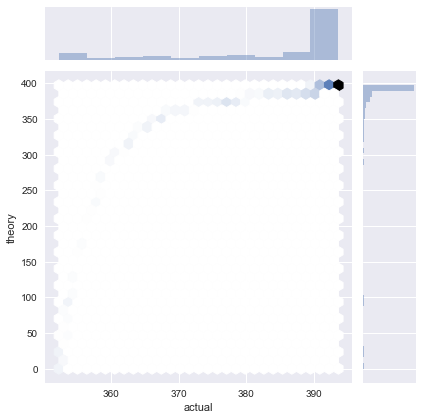

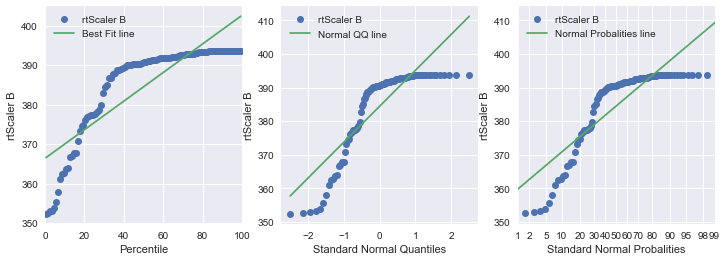

<Figure size 288x288 with 0 Axes>

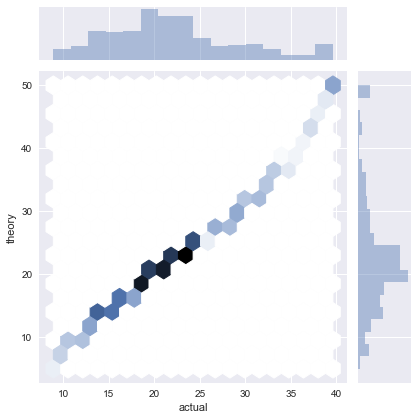

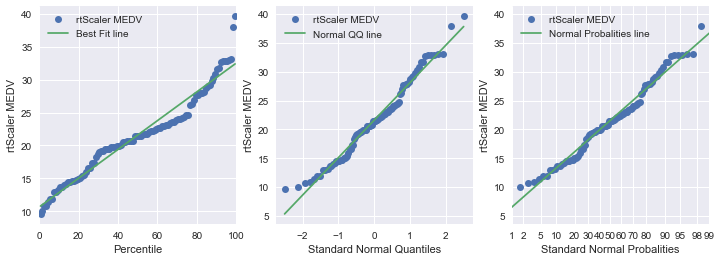

<Figure size 288x288 with 0 Axes>

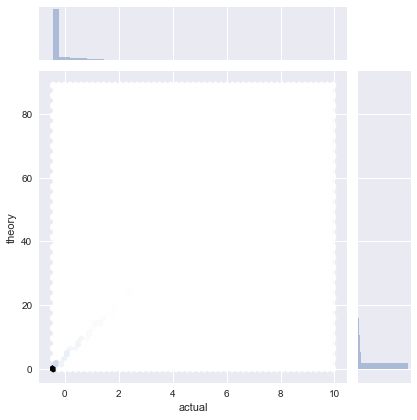

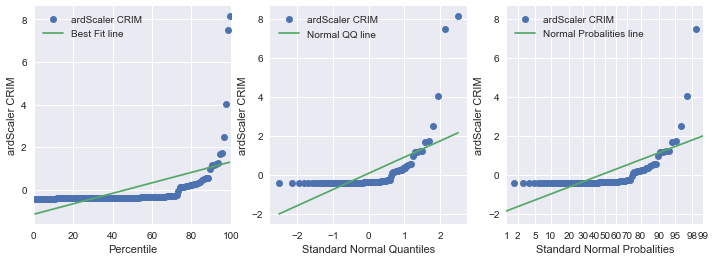

<Figure size 288x288 with 0 Axes>

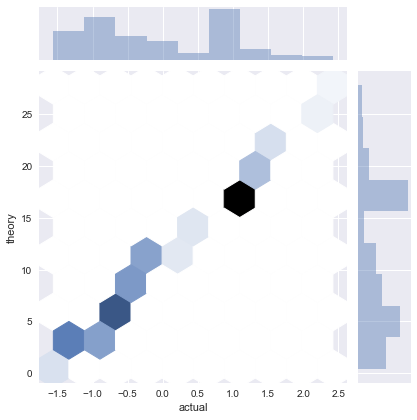

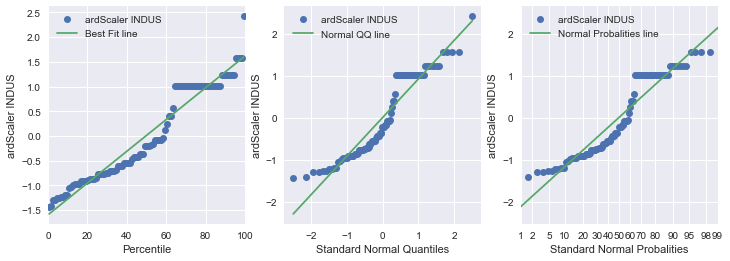

<Figure size 288x288 with 0 Axes>

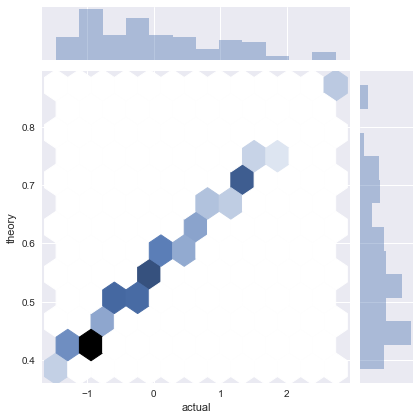

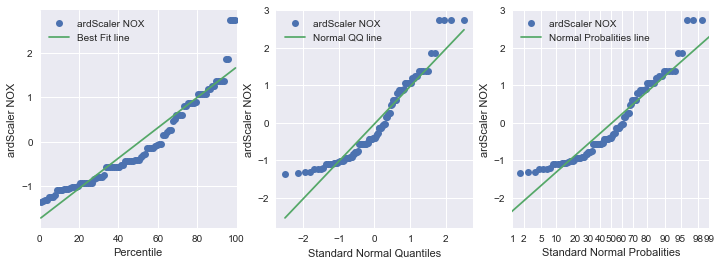

<Figure size 288x288 with 0 Axes>

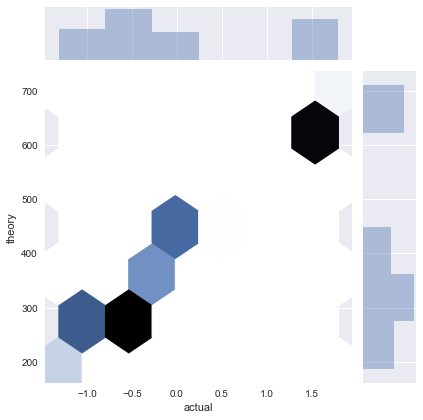

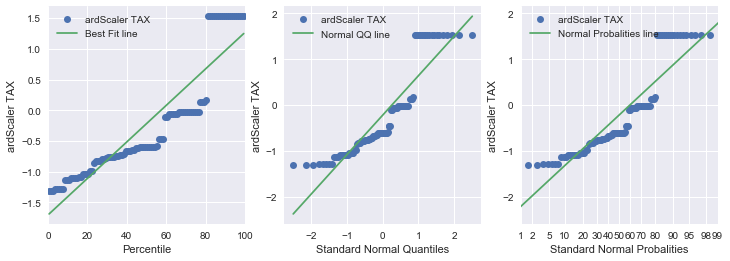

<Figure size 288x288 with 0 Axes>

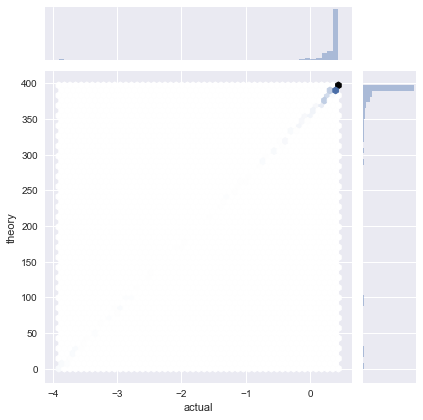

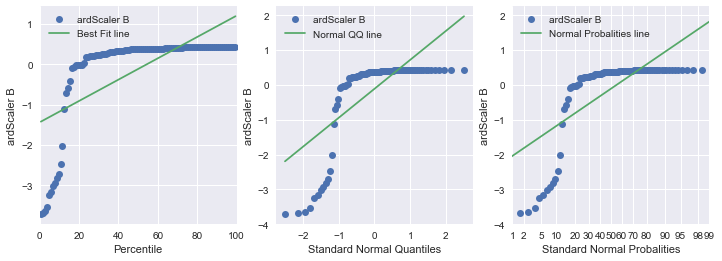

<Figure size 288x288 with 0 Axes>

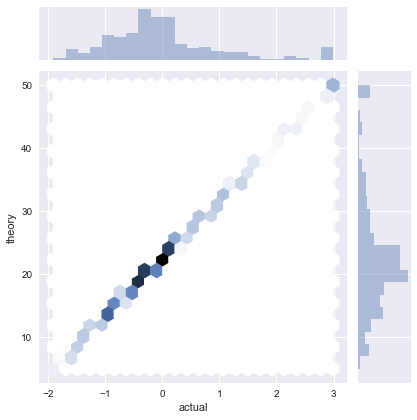

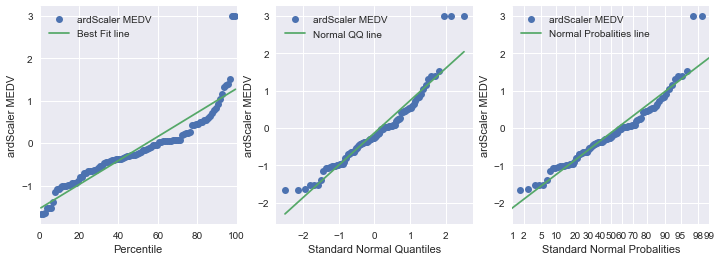

<Figure size 288x288 with 0 Axes>

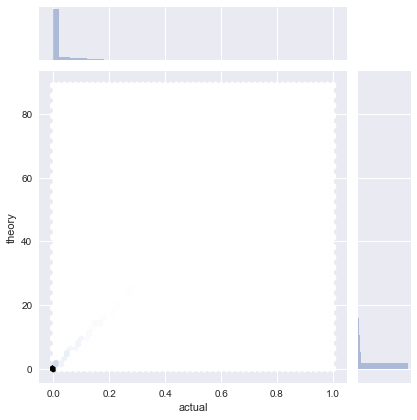

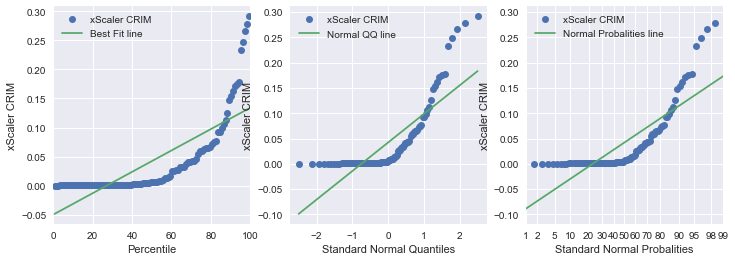

<Figure size 288x288 with 0 Axes>

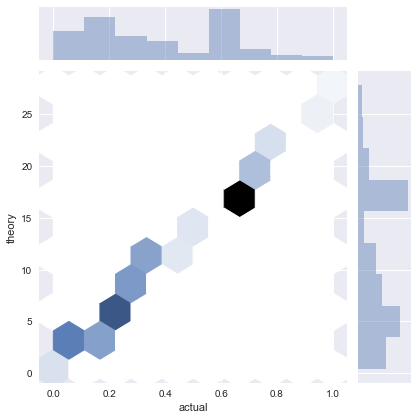

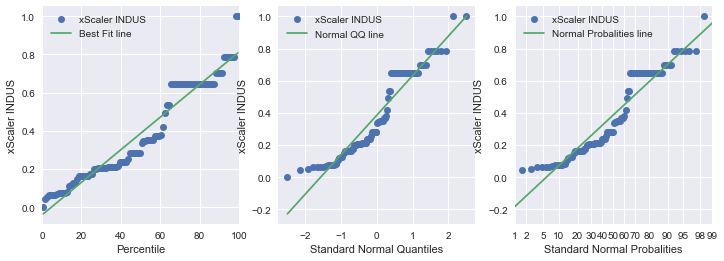

<Figure size 288x288 with 0 Axes>

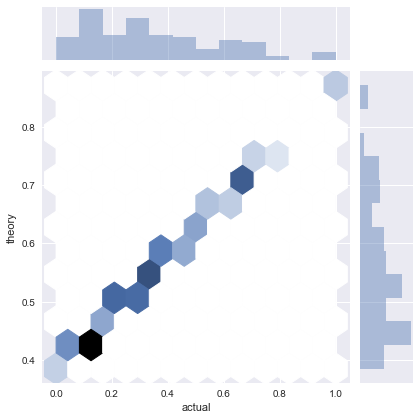

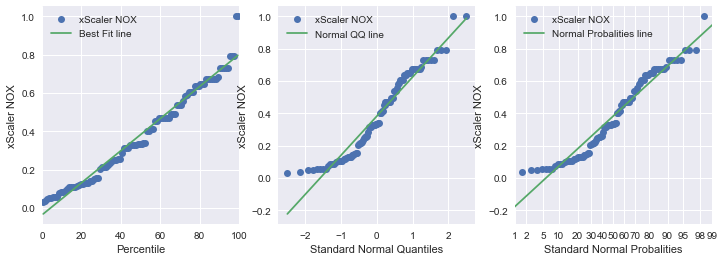

<Figure size 288x288 with 0 Axes>

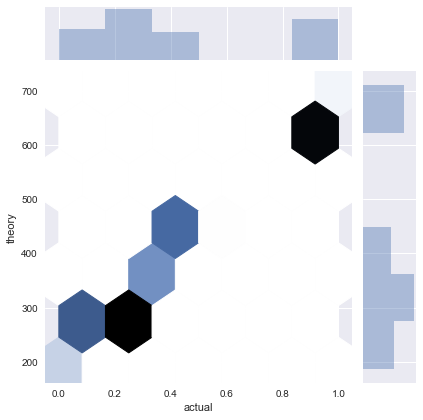

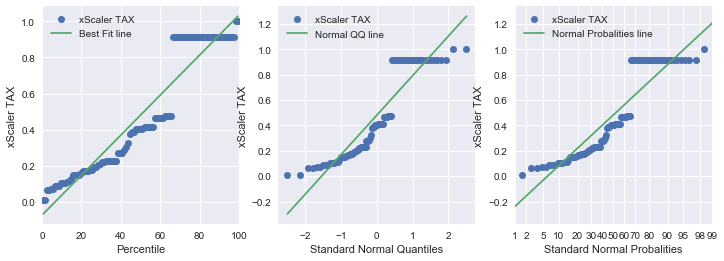

<Figure size 288x288 with 0 Axes>

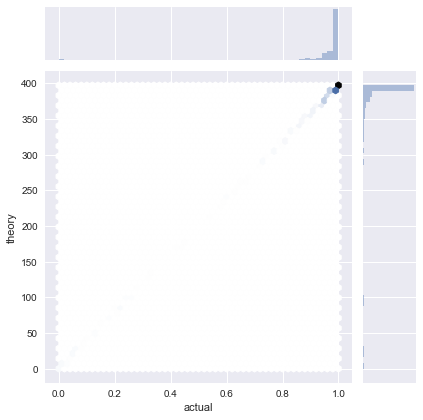

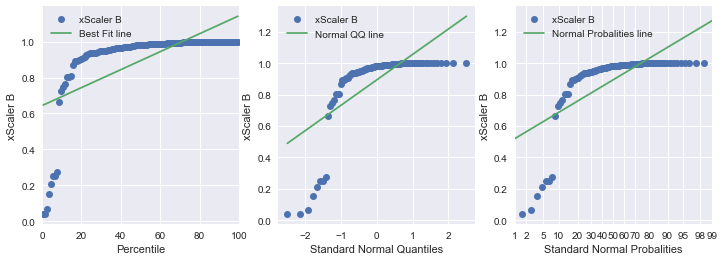

<Figure size 288x288 with 0 Axes>

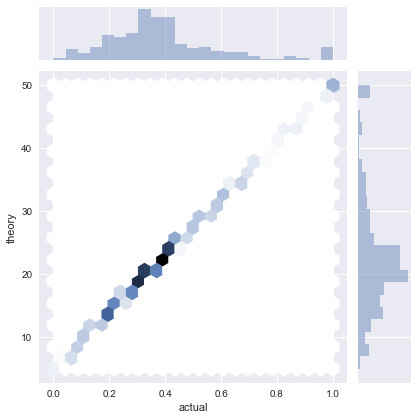

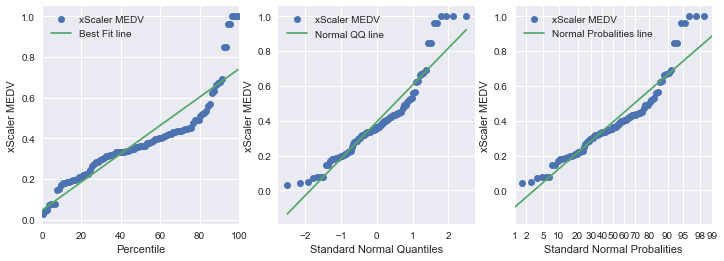

In [48]:
for Plot_Gaussian_step_nth in Plot_Gaussian_step:  
        Plot_Gaussian_step_nth.fit_transform(data_City)


### Hip_m Plot_Gaussian_step

for Plot_Gaussian_step_nth in Plot_Gaussian_step:  
    try: Plot_Gaussian_step_nth.fit_transform(data_Hip_m)
    except: pass

# References

## Compare the effect of different scalers on data with outliers¶
- Author:  Raghav RV <rvraghav93@gmail.com>
-           Guillaume Lemaitre <g.lemaitre58@gmail.com>
-          Thomas Unterthiner
-  License: BSD 3 clause
- http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

## Better ways to do One Hot Encoding
- by Tukey
- http://tukeys.blogspot.com/2017/05/better-ways-to-do-one-hot-encoding.html

## 1st place with representation learning (RankGauss)
- by Michael Jahrer
- https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629#260408

## Preparing continuous features for neural networks with GaussRank
- by y Zygmunt Z. 
- http://fastml.com/preparing-continuous-features-for-neural-networks-with-rankgauss/
- https://github.com/zygmuntz/gaussrank

## Plotting Class: SeabornFig2Grid
- https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot

## A closer look at probability plots
- https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html#overview

## Spacing measures: heterogeneity in numerical distributions
- http://exploringdatablog.blogspot.com/2012/09/spacing-measures-heterogeneity-in.html